In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/optiver_real_vol')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')




Mounted at /content/drive
Wed Aug 21 08:43:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              47W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------

In [2]:

import pandas as pd
import numpy as np
from numba import njit

import glob
import pickle

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

import scipy.stats as stats

### DATA MUNGING for HAR features extraction

In [ ]:
"""
HAR models forecasting realized volatility

"""


# def log_return(list_stock_prices):
#     return np.append(np.diff(np.log(list_stock_prices)),np.nan) ## append to match length, its dropped later

# def realized_volatility(series_log_return):
#     return np.sqrt(np.sum(series_log_return**2))

# def realized_quarticity(log_returns):
#     return np.sum(log_returns**4) / len(log_returns)

# def bipower_variation(log_returns):
#     log_returns = log_returns.values
#     bpv = 0
#     for i in range(len(log_returns) - 1):
#         bpv += np.abs(log_returns[i] * log_returns[i+1])
#     return (np.sqrt(2 / np.pi)) ** (-2) * bpv

# def positive_realized_semivariance(log_returns):
#     log_returns = log_returns.values
#     positive_returns = log_returns[log_returns > 0]
#     return np.sum(positive_returns**2) / len(positive_returns)

# def negative_realized_semivariance(log_returns):
#     log_returns = log_returns.values
#     negative_returns = log_returns[log_returns < 0]
#     return np.sum(negative_returns**2) / len(negative_returns)



@njit
def log_return(prices):
    return np.append(np.diff(np.log(prices)),np.nan) ## append to match length, its dropped later

@njit
def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

@njit
def realized_quarticity(log_returns):
    return (np.sum(log_returns**4) * len(log_returns)) / 3

@njit
def bipower_variation(log_returns):
    abs_log_returns = np.abs(log_returns)
    return (np.pi / 2) * np.sum(abs_log_returns[:-1] * abs_log_returns[1:])

@njit
def positive_realized_semivariance(log_returns):
    return np.sum(np.where(log_returns > 0, log_returns**2, 0))

@njit
def negative_realized_semivariance(log_returns):
    return np.sum(np.where(log_returns < 0, log_returns**2, 0))

In [ ]:
# def book_wap1_HAR_estimator(subset_paths,train_target):

#     book_wap1_HAR_df = pd.DataFrame()

#     for path in subset_paths:
#         print(path)
#         st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
#         # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
#         if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
#           df_book_data = pd.read_parquet(path)
#           df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
#                                       df_book_data['bid_size1']+ df_book_data[
#                                   'ask_size1'])
#           df_book_data['log_ret_price'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return).values
#           df_book_data = df_book_data[~df_book_data['log_ret_price'].isnull()]
#           train_st = df_book_data
#           df_realized_vol_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(realized_volatility)).rename(columns={'log_ret_price':'book_real_vol_price'})
#           df_realized_quart_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(realized_quarticity)).rename(columns={'log_ret_price':'book_real_quart_price'})
#           df_realized_bpv_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(bipower_variation)).rename(columns={'log_ret_price':'book_real_bpv_price'})
#           df_realized_pos_semvar_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(positive_realized_semivariance)).rename(columns={'log_ret_price':'book_real_pos_semvar_price'})
#           df_realized_neg_semvar_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(negative_realized_semivariance)).rename(columns={'log_ret_price':'book_real_neg_semvar_price'})

#           target_st =train_target[train_target['stock_id']==st_id] # use when not called above
#           target_st.index = [target_st["time_id"]] # use when not called above
#           common_time_id = np.intersect1d(df_realized_vol_per_stock.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
#           har_estimates_df = pd.DataFrame()
#           har_estimates_df['book_real_vol_price'] = df_realized_vol_per_stock.loc[common_time_id,"book_real_vol_price"].values
#           har_estimates_df['book_real_quart_price'] = df_realized_quart_per_stock.loc[common_time_id,"book_real_quart_price"].values
#           har_estimates_df['book_real_bpv_price'] = df_realized_bpv_per_stock.loc[common_time_id,"book_real_bpv_price"].values
#           har_estimates_df['book_real_pos_semvar_price'] = df_realized_pos_semvar_per_stock.loc[common_time_id,"book_real_pos_semvar_price"].values
#           har_estimates_df['book_real_neg_semvar_price'] = df_realized_neg_semvar_per_stock.loc[common_time_id,"book_real_neg_semvar_price"].values
#           har_estimates_df['target_vol'] = target_st.loc[common_time_id,"target"].values
#           har_estimates_df['st_id'] = np.repeat(st_id,len(common_time_id))
#           har_estimates_df['time_id'] = common_time_id

#           book_wap1_HAR_df = pd.concat([book_wap1_HAR_df,har_estimates_df])

#     book_wap1_HAR_df.index = range(len(book_wap1_HAR_df))
#     return book_wap1_HAR_df





def book_wap1_HAR_estimator(subset_paths, train_target):
    book_wap1_HAR_df = pd.DataFrame()

    for path in subset_paths:
        print(path)
        st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

        # Process data only for valid stock IDs
        if st_id != -1:  # Modify this list if needed to exclude specific stock IDs

            df_book_data = pd.read_parquet(path)

            # Calculate WAP
            df_book_data['wap'] = (df_book_data['bid_price1'] * df_book_data['ask_size1'] +
                                   df_book_data['ask_price1'] * df_book_data['bid_size1']) / (
                                    df_book_data['bid_size1'] + df_book_data['ask_size1'])

            # Calculate log returns using transform to maintain the original DataFrame length
            df_book_data['log_ret_price'] = df_book_data.groupby(['time_id'])['wap'].transform(
                lambda x: log_return(x.to_numpy())
            )

            # Remove NaN values resulting from log return calculation
            df_book_data = df_book_data.dropna(subset=['log_ret_price'])

            # Group by time_id and calculate HAR features
            df_realized_vol_per_stock = df_book_data.groupby('time_id')['log_ret_price'].agg(
                realized_volatility).rename('book_real_vol_price')
            df_realized_quart_per_stock = df_book_data.groupby('time_id')['log_ret_price'].agg(
                realized_quarticity).rename('book_real_quart_price')
            df_realized_bpv_per_stock = df_book_data.groupby('time_id')['log_ret_price'].agg(
                bipower_variation).rename('book_real_bpv_price')
            df_realized_pos_semvar_per_stock = df_book_data.groupby('time_id')['log_ret_price'].agg(
                positive_realized_semivariance).rename('book_real_pos_semvar_price')
            df_realized_neg_semvar_per_stock = df_book_data.groupby('time_id')['log_ret_price'].agg(
                negative_realized_semivariance).rename('book_real_neg_semvar_price')

            # Align with target data
            target_st = train_target[train_target['stock_id'] == st_id].set_index('time_id')
            common_time_id = np.intersect1d(df_realized_vol_per_stock.index, target_st.index)

            # Create HAR estimates DataFrame for common time IDs
            har_estimates_df = pd.DataFrame({
                'book_real_vol_price': df_realized_vol_per_stock.loc[common_time_id],
                'book_real_quart_price': df_realized_quart_per_stock.loc[common_time_id],
                'book_real_bpv_price': df_realized_bpv_per_stock.loc[common_time_id],
                'book_real_pos_semvar_price': df_realized_pos_semvar_per_stock.loc[common_time_id],
                'book_real_neg_semvar_price': df_realized_neg_semvar_per_stock.loc[common_time_id],
                'target_vol': target_st.loc[common_time_id, 'target'].values,
                'st_id': np.repeat(st_id, len(common_time_id)),
                'time_id': common_time_id
            })

            # Concatenate results
            book_wap1_HAR_df = pd.concat([book_wap1_HAR_df, har_estimates_df])

    book_wap1_HAR_df.reset_index(drop=True, inplace=True)
    return book_wap1_HAR_df


In [ ]:

# def trade_HAR_estimator(subset_paths,train_target):

#     trade_HAR_df = pd.DataFrame()

#     for path in subset_paths:
#         print(path)
#         st_id = int(path.split('/')[1].split('_')[1].split('=')[1])
#         # stock ids in [103,18,31,37] have DIFFERENT length of time_id compared to target so we exclude them for now
#         if st_id != -1:#not in [103,18,31,37,110]: # select stock id here
#           train_st = pd.read_parquet(path)

#           print(train_st["time_id"])
#           ## compute realized volality in the first 10 mins using trade execution price (instead of WAP)
#           train_st['log_ret_price'] = train_st.groupby(by='time_id')['price'].apply(log_return).values
#           train_st = train_st[~train_st['log_ret_price'].isnull()]
#           df_realized_vol_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(realized_volatility)).rename(columns={'log_ret_price':'real_vol_price'})
#           df_realized_quart_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(realized_quarticity)).rename(columns={'log_ret_price':'real_quart_price'})
#           df_realized_bpv_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(bipower_variation)).rename(columns={'log_ret_price':'real_bpv_price'})
#           df_realized_pos_semvar_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(positive_realized_semivariance)).rename(columns={'log_ret_price':'real_pos_semvar_price'})
#           df_realized_neg_semvar_per_stock =  pd.DataFrame(train_st.groupby(['time_id'])['log_ret_price'].agg(negative_realized_semivariance)).rename(columns={'log_ret_price':'real_neg_semvar_price'})

#           target_st =train_target[train_target['stock_id']==st_id] # use when not called above
#           target_st.index = [target_st["time_id"]] # use when not called above
#           common_time_id = np.intersect1d(df_realized_vol_per_stock.index.values, target_st['time_id'].values) # ensure that only common time ids in trade_train and target are used.
#           har_estimates_df = pd.DataFrame()
#           har_estimates_df['real_vol_price'] = df_realized_vol_per_stock.loc[common_time_id,"real_vol_price"].values
#           har_estimates_df['real_quart_price'] = df_realized_quart_per_stock.loc[common_time_id,"real_quart_price"].values
#           har_estimates_df['real_bpv_price'] = df_realized_bpv_per_stock.loc[common_time_id,"real_bpv_price"].values
#           har_estimates_df['real_pos_semvar_price'] = df_realized_pos_semvar_per_stock.loc[common_time_id,"real_pos_semvar_price"].values
#           har_estimates_df['real_neg_semvar_price'] = df_realized_neg_semvar_per_stock.loc[common_time_id,"real_neg_semvar_price"].values
#           har_estimates_df['target_vol'] = target_st.loc[common_time_id,"target"].values
#           har_estimates_df['st_id'] = np.repeat(st_id,len(common_time_id))
#           har_estimates_df['time_id'] = common_time_id

#           trade_HAR_df = pd.concat([trade_HAR_df,har_estimates_df])

#     trade_HAR_df.index = range(len(trade_HAR_df))
#     return trade_HAR_df



def trade_HAR_estimator(subset_paths, train_target):
    trade_HAR_df = pd.DataFrame()

    for path in subset_paths:
        print(path)
        st_id = int(path.split('/')[1].split('_')[1].split('=')[1])

        if st_id != -1:
            train_st = pd.read_parquet(path)

            # Convert price series to numpy array before applying Numba-optimized functions
            train_st['log_ret_price'] = train_st.groupby('time_id')['price'].transform(lambda x: log_return(x.to_numpy()))

            # Drop NaNs resulting from log returns
            train_st = train_st.dropna(subset=['log_ret_price'])

            # Aggregate using Numba-optimized functions, converting to numpy first
            vol_per_stock = train_st.groupby('time_id')['log_ret_price'].apply(lambda x: realized_volatility(x.to_numpy()))
            quart_per_stock = train_st.groupby('time_id')['log_ret_price'].apply(lambda x: realized_quarticity(x.to_numpy()))
            bpv_per_stock = train_st.groupby('time_id')['log_ret_price'].apply(lambda x: bipower_variation(x.to_numpy()))
            pos_semvar_per_stock = train_st.groupby('time_id')['log_ret_price'].apply(lambda x: positive_realized_semivariance(x.to_numpy()))
            neg_semvar_per_stock = train_st.groupby('time_id')['log_ret_price'].apply(lambda x: negative_realized_semivariance(x.to_numpy()))

            # Rename columns
            df_realized_vol_per_stock = pd.DataFrame(vol_per_stock).rename(columns={'log_ret_price':'real_vol_price'})
            df_realized_quart_per_stock = pd.DataFrame(quart_per_stock).rename(columns={'log_ret_price':'real_quart_price'})
            df_realized_bpv_per_stock = pd.DataFrame(bpv_per_stock).rename(columns={'log_ret_price':'real_bpv_price'})
            df_realized_pos_semvar_per_stock = pd.DataFrame(pos_semvar_per_stock).rename(columns={'log_ret_price':'real_pos_semvar_price'})
            df_realized_neg_semvar_per_stock = pd.DataFrame(neg_semvar_per_stock).rename(columns={'log_ret_price':'real_neg_semvar_price'})

            # Target stock
            target_st = train_target[train_target['stock_id'] == st_id]
            target_st.index = target_st["time_id"]

            # Ensure common time IDs
            common_time_id = np.intersect1d(df_realized_vol_per_stock.index.values, target_st['time_id'].values)

            # Prepare the HAR estimates DataFrame
            har_estimates_df = pd.DataFrame()
            har_estimates_df['real_vol_price'] = df_realized_vol_per_stock.loc[common_time_id, "real_vol_price"].values
            har_estimates_df['real_quart_price'] = df_realized_quart_per_stock.loc[common_time_id, "real_quart_price"].values
            har_estimates_df['real_bpv_price'] = df_realized_bpv_per_stock.loc[common_time_id, "real_bpv_price"].values
            har_estimates_df['real_pos_semvar_price'] = df_realized_pos_semvar_per_stock.loc[common_time_id, "real_pos_semvar_price"].values
            har_estimates_df['real_neg_semvar_price'] = df_realized_neg_semvar_per_stock.loc[common_time_id, "real_neg_semvar_price"].values
            har_estimates_df['target_vol'] = target_st.loc[common_time_id, "target"].values
            har_estimates_df['st_id'] = np.repeat(st_id, len(common_time_id))
            har_estimates_df['time_id'] = common_time_id

            # Concatenate results
            trade_HAR_df = pd.concat([trade_HAR_df, har_estimates_df])

    trade_HAR_df.index = range(len(trade_HAR_df))
    return trade_HAR_df

In [ ]:
"""
Create HAR features for book data
"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/optimus_GPU_data/data')
subset_paths = sorted(glob.glob('book_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
train_target = pd.read_csv('train.csv')
book_wap1_HAR_vol_estimates_df = book_wap1_HAR_estimator(subset_paths,train_target)
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
pickle.dump(book_wap1_HAR_vol_estimates_df, open('book_wap1_HAR_vol_estimates_df.pkl', 'wb'))


In [ ]:
"""
reordering time_ids to correct order for book data
"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets')
correct_time_id_order = pickle.load(open('correct_time_id_order.pkl','rb'))

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
book_wap1_HAR_vol_estimates_full_df = pickle.load(open('book_wap1_HAR_vol_estimates_df.pkl', 'rb'))
#book_wap1_HAR_vol_estimates_full_df = pickle.load(open('book_wap1_HAR_vol_estimates_full_df.pkl', 'rb'))

# reorder time_ids to correct order

def my_reorder_stock_in_df(df, time_ids_reordered):
    common_values = [value for value in time_ids_reordered if value in df['time_id'].values]
    df = df.set_index('time_id')
    df = df.reindex(common_values)
    df['time_id'] = df.index
    return df


# Assuming you have a dataframe called 'df' and an array of reordered time_ids called 'time_ids_reordered'
HAR_book_wap1_data_reordered = book_wap1_HAR_vol_estimates_full_df.groupby('st_id').apply(my_reorder_stock_in_df ,time_ids_reordered=correct_time_id_order).reset_index(drop=True)
HAR_book_wap1_data_reordered

#### Load the dataset
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
pickle.dump(HAR_book_wap1_data_reordered,open('book_wap1_HAR_vol_estimates_reordered_df.pkl', 'wb'))



In [ ]:
"""
Create HAR features for trade data
"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/optimus_GPU_data/data')
subset_paths = sorted(glob.glob('trade_train.parquet/stock_id=*'), key=lambda x: int(x.split('=')[1]))
train_target = pd.read_csv('train.csv')
trade_HAR_vol_estimates_df = trade_HAR_estimator(subset_paths,train_target)
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
pickle.dump(trade_HAR_vol_estimates_df, open('trade_HAR_vol_estimates_df.pkl', 'wb'))

In [ ]:


"""
reordering time_ids to correct order for trade wap1 data
"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets')
correct_time_id_order = pickle.load(open('correct_time_id_order.pkl','rb'))

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
trade_HAR_vol_estimates_df = pickle.load(open('trade_HAR_vol_estimates_df.pkl', 'rb'))


# reorder time_ids to correct order

def my_reorder_stock_in_df(df, time_ids_reordered):
    common_values = [value for value in time_ids_reordered if value in df['time_id'].values]
    df = df.set_index('time_id')
    df = df.reindex(common_values)
    df['time_id'] = df.index
    return df

# Assuming you have a dataframe called 'df' and an array of reordered time_ids called 'time_ids_reordered'
HAR_trade_data_reordered = trade_HAR_vol_estimates_df.groupby('st_id').apply(my_reorder_stock_in_df, time_ids_reordered=correct_time_id_order).reset_index(drop=True)
HAR_trade_data_reordered


#### Load the dataset
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_book_wap1_data_reordered = pickle.load(open('book_wap1_HAR_vol_estimates_reordered_df.pkl', 'rb'))
temp_df = HAR_book_wap1_data_reordered.drop(columns=['target_vol', 'book_real_vol_price', 'book_real_quart_price', 'book_real_bpv_price', 'book_real_pos_semvar_price', 'book_real_neg_semvar_price'])
temp_df

### fill the missing time ids in trade data to match with length of book data
HAR_trade_data_reordered_df = pd.merge(temp_df,HAR_trade_data_reordered, left_on=['st_id','time_id'], right_on=['st_id','time_id'], how='left').ffill().bfill()
HAR_trade_data_reordered_df

#### save the dataset
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
pickle.dump(HAR_trade_data_reordered_df,open('trade_HAR_vol_estimates_reordered_df.pkl', 'wb'))

In [ ]:
book_wap1_HAR_vol_estimates_full_df

,book_real_vol_price,book_real_quart_price,book_real_bpv_price,book_real_pos_semvar_price,book_real_neg_semvar_price,target_vol,st_id,time_id
0,0.007026,5.283978e-13,4.169624e-05,2.168871e-07,4.291532e-07,0.003267,0,4294
1,0.001474,1.827834e-15,9.639366e-07,1.829129e-08,1.684700e-08,0.001508,0,31984
2,0.000891,2.215738e-16,3.527636e-07,5.525326e-09,4.689908e-09,0.001326,0,31570
3,0.002395,3.136591e-15,3.698405e-06,2.412260e-08,2.120292e-08,0.002051,0,5666
4,0.001790,1.538828e-15,2.094555e-06,1.853102e-08,2.159987e-08,0.002364,0,29740
...,...,...,...,...,...,...,...,...
428927,0.007303,2.126995e-13,3.716398e-05,2.829112e-07,1.934924e-07,0.006360,126,24913
428928,0.005740,1.611561e-13,1.871075e-05,2.685819e-07,1.225794e-07,0.004802,126,15365
428929,0.004781,5.479353e-14,1.156482e-05,1.644787e-07,9.376588e-08,0.003397,126,29316
428930,0.006109,1.301908e-13,2.047856e-05,1.830165e-07,2.332819e-07,0.005479,126,32195


#### Training the HAR model for prediction

In [3]:
"""
load book wap1 HAR features
"""
os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
book_wap1_HAR_vol_estimates_full_df = pickle.load(open('book_wap1_HAR_vol_estimates_reordered_df.pkl', 'rb'))

book_wap1_HAR_vol_estimates_full_df = book_wap1_HAR_vol_estimates_full_df.rename(columns={'book_real_vol_price':'RV','book_real_quart_price': 'RQ', 'book_real_bpv_price': 'BPV', 'book_real_pos_semvar_price': 'RV_plus', 'book_real_neg_semvar_price': 'RV_minus'})
book_wa1_HAR_vol_estimates_df = book_wap1_HAR_vol_estimates_full_df.drop(columns=['target_vol','st_id',	'time_id'])
# book_wa1_HAR_vol_estimates_df



In [ ]:
book_wap1_HAR_vol_estimates_full_df

,RV,RQ,BPV,RV_plus,RV_minus,target_vol,st_id,time_id
0,0.007026,5.283978e-13,4.169624e-05,2.168871e-07,4.291532e-07,0.003267,0,4294
1,0.001474,1.827834e-15,9.639366e-07,1.829129e-08,1.684700e-08,0.001508,0,31984
2,0.000891,2.215738e-16,3.527636e-07,5.525326e-09,4.689908e-09,0.001326,0,31570
3,0.002395,3.136591e-15,3.698405e-06,2.412260e-08,2.120292e-08,0.002051,0,5666
4,0.001790,1.538828e-15,2.094555e-06,1.853102e-08,2.159987e-08,0.002364,0,29740
...,...,...,...,...,...,...,...,...
428927,0.007303,2.126995e-13,3.716398e-05,2.829112e-07,1.934924e-07,0.006360,126,24913
428928,0.005740,1.611561e-13,1.871075e-05,2.685819e-07,1.225794e-07,0.004802,126,15365
428929,0.004781,5.479353e-14,1.156482e-05,1.644787e-07,9.376588e-08,0.003397,126,29316
428930,0.006109,1.301908e-13,2.047856e-05,1.830165e-07,2.332819e-07,0.005479,126,32195


In [4]:
"""
load trade HAR features
"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
trade_HAR_vol_estimates_full_df = pickle.load(open('trade_HAR_vol_estimates_reordered_df.pkl', 'rb'))

trade_HAR_vol_estimates_full_df = trade_HAR_vol_estimates_full_df.rename(columns={'real_vol_price':'RV','real_quart_price': 'RQ', 'real_bpv_price': 'BPV', 'real_pos_semvar_price': 'RV_plus', 'real_neg_semvar_price': 'RV_minus'})
trade_HAR_vol_estimates_df = trade_HAR_vol_estimates_full_df.drop(columns=['target_vol','st_id',	'time_id'])

## reorder columns
st_id = trade_HAR_vol_estimates_full_df['st_id']
time_id =  trade_HAR_vol_estimates_full_df['time_id']
trade_HAR_vol_estimates_full_df = trade_HAR_vol_estimates_full_df.drop(columns=['st_id',	'time_id'])
trade_HAR_vol_estimates_full_df['st_id'] = st_id
trade_HAR_vol_estimates_full_df['time_id'] = time_id
trade_HAR_vol_estimates_full_df

#trade_HAR_vol_estimates_df

,RV,RQ,BPV,RV_plus,RV_minus,target_vol,st_id,time_id
0,0.003655,1.719227e-10,1.002870e-05,9.703328e-06,3.653923e-06,0.003267,0,4294
1,0.000883,4.454985e-13,7.756357e-07,5.500052e-07,2.292416e-07,0.001508,0,31984
2,0.000814,3.740470e-13,7.144235e-07,4.274138e-07,2.346364e-07,0.001326,0,31570
3,0.000801,4.481962e-13,5.305640e-07,2.697829e-07,3.718768e-07,0.002051,0,5666
4,0.000861,5.502302e-13,6.454727e-07,4.749879e-07,2.671165e-07,0.002364,0,29740
...,...,...,...,...,...,...,...,...
428927,0.003977,2.242602e-10,1.380073e-05,9.758118e-06,6.054688e-06,0.006360,126,24913
428928,0.003725,2.082454e-10,1.546365e-05,9.037874e-06,4.840214e-06,0.004802,126,15365
428929,0.002514,4.085838e-11,5.698833e-06,3.140760e-06,3.181337e-06,0.003397,126,29316
428930,0.003218,9.753775e-11,1.119458e-05,5.956608e-06,4.396420e-06,0.005479,126,32195


In [44]:
"""
FULL original HAR CODE from https://github.com/jacob-hein/HAR-models-forecasting-realized-volatility-in-US-stocks/tree/main

"""

def data_set_scalar(DataSet, scalar=100000):
    DataSet.iloc[:, 2:5] *= scalar # only multiply	BPV,	RV_plus,	RV_minus because its small
    DataSet.iloc[:, 1:2] *= scalar*scalar # only  RQ by scalar twice because its even smaller
    return DataSet



def HAR_initial_time_ids(data, out_sample):
    RV = data["target_vol"] # data['RV']
    RQ = data['RQ']
    BPV = data['BPV']
    RV_p = data['RV_plus']
    RV_m = data['RV_minus']

    nobs = len(RV)
    in_sample = nobs - out_sample

    outRV = RV[in_sample:]
    lag = 4 # 9 # 1 day = 9 time ids, 5 days (1 week) = 9*5 = 45 time ids
             # NOTE: lag has to be >= longest look back period. e.g. if  sum (mean) of past terms in HAR model below is 22 periods then  lag >= 22
             # in code below, lookback is 9 time ids and 45 time ids. i.e. 1 day and 5 days.

    all_predsA = np.zeros(out_sample)
    all_preds = np.zeros(out_sample)
    all_predsQ = np.zeros(out_sample)
    all_predsF = np.zeros(out_sample)
    all_predsC = np.zeros(out_sample)
    all_predsS = np.zeros(out_sample)
    all_predsJ = np.zeros(out_sample)

    all_betasA = np.zeros((out_sample, 4)) # variable for parameters, all_betasA axis 1 dim. is 1 larger than in XA due to intercept term
    all_betas = np.zeros((out_sample, 4))
    all_betasQ = np.zeros((out_sample, 5))
    all_betasF = np.zeros((out_sample, 7))
    all_betasC = np.zeros((out_sample, 4))
    all_betasS = np.zeros((out_sample, 5))
    all_betasJ = np.zeros((out_sample, 5))

    ## make single step predictions each time,t
    for t in range(out_sample):
        # Estimation
        #print(f'y first index {(lag + t + 1)}' )
        #print(f'in_sample {in_sample}' )
        y = RV[lag + t + 1: in_sample + t + 1]
        XA = np.zeros((in_sample - lag, 3)) # variable for data points
        X = np.zeros((in_sample - lag, 3))
        XQ = np.zeros((in_sample - lag, 4))
        XF = np.zeros((in_sample - lag, 6))
        XC = np.zeros((in_sample - lag, 3))
        XS = np.zeros((in_sample - lag, 4))
        XJ = np.zeros((in_sample - lag, 4))

        for i in range(in_sample - lag ):
            #print(f'x first index {(-1 + i + 1 + lag + t)}' )
            # AR(3)
            XA[i, 0] = RV[-1 + i + 1 + lag + t]
            XA[i, 1] = RV[-2 + i + 1 + lag + t]
            XA[i, 2] = RV[-3 + i + 1 + lag + t]

            # HAR
            X[i, 0] = RV[-1 + i + 1 + lag + t]
            X[i, 1] = np.mean(RV[-2 + i + 1 + lag + t: i + lag + t])
            X[i, 2] = np.mean(RV[-4 + i + 1 + lag + t: i + lag + t])

            # HARQ
            XQ[i, 0] = RV[-1 + i + 1 + lag + t]
            XQ[i, 1] = np.mean(RV[-2 + i + 1 + lag + t: i + lag + t])
            XQ[i, 2] = np.mean(RV[-4 + i + 1 + lag + t: i + lag + t])
            XQ[i, 3] = np.sqrt(RQ[-1 + i + 1 + lag + t]) * RV[-1 + i + 1 + lag + t]

            # HARQ-F
            XF[i, 0] = RV[-1 + i + 1 + lag + t]
            XF[i, 1] = np.mean(RV[-2 + i + 1 + lag + t: i + lag + t])
            XF[i, 2] = np.mean(RV[-4 + i + 1 + lag + t: i + lag + t])
            XF[i, 3] = np.sqrt(RQ[-1 + i + 1 + lag + t]) * RV[-1 + i + 1 + lag + t]
            XF[i, 4] = np.sqrt(np.mean(RQ[-2 + i + 1 + lag + t: i + lag + t])) * np.sqrt(np.mean(RV[-2 + i + 1 + lag + t: i + lag + t]))
            XF[i, 5] = np.sqrt(np.mean(RQ[-4 + i + 1 + lag + t: i + lag + t])) * np.sqrt(np.mean(RV[-4 + i + 1 + lag + t: i + lag + t]))

            # CHAR
            XC[i, 0] = BPV[-1 + i + 1 + lag + t]
            XC[i, 1] = np.mean(BPV[-2 + i + 1 + lag + t: i + lag + t])
            XC[i, 2] = np.mean(BPV[-4 + i + 1 + lag + t: i + lag + t])

            # SHAR
            XS[i, 0] = np.mean(RV[-2 + i + 1 + lag + t: i + lag + t])
            XS[i, 1] = np.mean(RV[-4 + i + 1 + lag + t: i + lag + t])
            XS[i, 2] = RV_p[-1 + i + 1 + lag + t]
            XS[i, 3] = RV_m[-1 + i + 1 + lag + t]

            # HAR-J
            XJ[i, 0] = RV[-1 + i + 1 + lag + t]
            XJ[i, 1] = np.mean(RV[-2 + i + 1 + lag + t: i + lag + t])
            XJ[i, 2] = np.mean(RV[-4 + i + 1 + lag + t: i + lag + t])
            XJ[i, 3] = max(RV[-1 + i + 1 + lag + t] - BPV[-1 + i + 1 + lag + t], 0)

        ### remove the last entry in Xs and ys during fitting to prevent lookahead bias
        XA = np.column_stack([np.ones(len(XA)), XA ]) # ones column concatenated to data for the intercept term.
        X = np.column_stack([np.ones(len(X)), X])
        XQ = np.column_stack([np.ones(len(XQ)), XQ])
        XF = np.column_stack([np.ones(len(XF)), XF])
        XC = np.column_stack([np.ones(len(XC)), XC])
        XS = np.column_stack([np.ones(len(XS)), XS])
        XJ = np.column_stack([np.ones(len(XJ)), XJ])

        # print('Full XA including prediction index = ' ,XA.shape)
        # print('Full y including prediction index = ',y.shape)

        I = np.eye(X[:-1,:].shape[1])
        lambda_reg = 1e-5  # Adjust this value as needed

        ### remove the last entry in Xs and ys during fitting to prevent lookahead bias
        betasA = np.linalg.lstsq(XA[:-1,:], y[:-1], rcond=None)[0] # solve least squares
        betas = np.linalg.lstsq(X[:-1,:] + lambda_reg, y[:-1], rcond=None)[0]
        betasQ = np.linalg.lstsq(XQ[:-1,:], y[:-1], rcond=None)[0]
        betasF = np.linalg.lstsq(XF[:-1,:], y[:-1], rcond=None)[0]
        betasC = np.linalg.lstsq(XC[:-1,:], y[:-1], rcond=None)[0]
        betasS = np.linalg.lstsq(XS[:-1,:], y[:-1], rcond=None)[0]
        betasJ = np.linalg.lstsq(XJ[:-1,:], y[:-1], rcond=None)[0]

        # print('XA[:-1,:] with prediction index excluded = ' ,XA[:-1,:].shape)
        # print('y[:-1] with prediction index excluded = ',y[:-1].shape)

        b0A, b1A, b2A, b3A = betasA
        b0, b1, b2, b3 = betas
        b0Q, b1Q, b2Q, b3Q, b1Q_Q = betasQ
        b0F, b1F, b2F, b3F, b1F_Q, b2F_Q, b3F_Q = betasF
        b0C, b1C, b2C, b3C = betasC
        b0S, b1S_P, b2S, b3S, b1S_M = betasS
        b0J, b1J, b2J, b3J, bJ = betasJ

        # print('betasA',betasA)
        # print('b0A, b1A, b2A, b3A ', b0A, b1A, b2A, b3A )

        all_betasA[t] = betasA
        all_betas[t] = betas
        all_betasQ[t] = betasQ
        all_betasF[t] = betasF
        all_betasC[t] = betasC
        all_betasS[t] = betasS
        all_betasJ[t] = betasJ

        # Prediction at time-step t
        #print(f"prediction time index in original data, RV[] : {in_sample + t}")

        predA = b0A + b1A * XA[-1, 1] + b2A * XA[-1, 2] + b3A * XA[-1, 3]
        pred = b0 + b1 * X[-1, 1] + b2 * X[-1, 2] + b3 * X[-1, 3]
        predQ = b0Q + b1Q * XQ[-1, 1] + b2Q * XQ[-1, 2] + b3Q * XQ[-1, 3] + b1Q_Q * XQ[-1, 4]
        predF = b0F + b1F * XF[-1, 1] + b2F * XF[-1, 2] + b3F * XF[-1, 3] + b1F_Q * XF[-1, 4] + b2F_Q * XF[-1, 5] + b3F_Q * XF[-1, 6]
        predC = b0C + b1C * XC[-1, 1] + b2C * XC[-1, 2] + b3C * XC[-1, 3]
        predS = b0S + b1S_P * XS[-1, 1] + b2S * XS[-1, 2] + b3S * XS[-1, 3] + b1S_M * XS[-1, 4]
        predJ = b0J + b1J * XJ[-1, 1] + b2J * XJ[-1, 2] + b3J * XJ[-1, 3] + bJ * XJ[-1, 4]

        # Saving time-step t prediction within list for error computations
        all_predsA[t] = predA
        all_preds[t] = pred
        all_predsQ[t] = predQ
        all_predsF[t] = predF
        all_predsC[t] = predC
        all_predsS[t] = predS
        all_predsJ[t] = predJ

        # this step is essentially performed at the last out of sample prediction
        # to measure model goodness of fit. It is esentially same as the least squares done abvoe.
        # Regression at t=1 for Standard Errors before performing any out-of-sample forecasts
        if t == out_sample - 1:
            modelA = LinearRegression().fit(XA[:-1,:], y[:-1])
            model = LinearRegression().fit(X[:-1,:], y[:-1])
            modelQ = LinearRegression().fit(XQ[:-1,:], y[:-1])
            modelF = LinearRegression().fit(XF[:-1,:], y[:-1])
            modelC = LinearRegression().fit(XC[:-1,:], y[:-1])
            modelS = LinearRegression().fit(XS[:-1,:], y[:-1])
            modelJ = LinearRegression().fit(XJ[:-1,:], y[:-1])

            models_at_t_1 = {"modelA": modelA, "model": model, "modelQ": modelQ, "modelF": modelF, "modelC": modelC,
                             "modelS": modelS, "modelJ": modelJ}

            x_data = [XA[:-1,:], X[:-1,:], XQ[:-1,:], XF[:-1,:], XC[:-1,:], XS[:-1,:], XJ[:-1,:]]
            y_data = [y[:-1], y[:-1], y[:-1], y[:-1], y[:-1], y[:-1], y[:-1]]

            # Below we retrieve R^2 & Adjusted R^2, prior to out-of-sample forecasts
            r_squareds = {"R-squared": [], "Adj.R-squared": []}
            for X,y, val in zip( x_data, y_data, models_at_t_1.values() ):
                r_squareds["R-squared"].append(val.score(X, y))
                r_squareds["Adj.R-squared"].append(1 - (1 - val.score(X, y)) * ((in_sample - lag - 1) / (in_sample - lag - 3)))


    # Error Computations: Mean Squared Error & Mean Absolute Error
    AR_mse = np.mean((outRV - all_predsA) ** 2)
    AR_mae = np.mean(np.abs(outRV - all_predsA))

    HAR_mse = np.mean((outRV - all_preds) ** 2)
    HAR_mae = np.mean(np.abs(outRV - all_preds))

    HARQ_mse = np.mean((outRV - all_predsQ) ** 2)
    HARQ_mae = np.mean(np.abs(outRV - all_predsQ))

    HARQF_mse = np.mean((outRV - all_predsF) ** 2)
    HARQF_mae = np.mean(np.abs(outRV - all_predsF))

    CHAR_mse = np.mean((outRV - all_predsC) ** 2)
    CHAR_mae = np.mean(np.abs(outRV - all_predsC))

    SHAR_mse = np.mean((outRV - all_predsS) ** 2)
    SHAR_mae = np.mean(np.abs(outRV - all_predsS))

    HARJ_mse = np.mean((outRV - all_predsJ) ** 2)
    HARJ_mae = np.mean(np.abs(outRV - all_predsJ))

    errors_list = {"AR_mse": AR_mse, "AR_mae": AR_mae, "HAR_mse": HAR_mse, "HAR_mae": HAR_mae,
                   "HARQ_mse": HARQ_mse, "HARQ_mae": HARQ_mae, "HARQF_mse": HARQF_mse, "HARQF_mae": HARQF_mae,
                   "CHAR_mse": CHAR_mse, "CHAR_mae": CHAR_mae, "SHAR_mse": SHAR_mse, "SHAR_mae": SHAR_mae,
                   "HARJ_mse": HARJ_mse, "HARJ_mae": HARJ_mae}

    # Output formatting:
    ## the index of this dataframe is correct, same as out of sample prediction index in original data, RV[].
    output_df = pd.DataFrame({"stock_id": data["st_id"][in_sample:],"time_id": data["time_id"][in_sample:], "outRV": outRV, "all_predsA": all_predsA,
                              "all_preds": all_preds, "all_predsQ": all_predsQ, "all_predsF": all_predsF,
                              "all_predsC": all_predsC, "all_predsS": all_predsS, "all_predsJ": all_predsJ})

    betas_list = {"all_betasA": all_betasA, "all_betas": all_betas, "all_betasQ": all_betasQ,
                  "all_betasF": all_betasF, "all_betasC": all_betasC, "all_betasS": all_betasS,
                  "all_betasJ": all_betasJ}

    output_df_errors_betas = [output_df, errors_list, betas_list, models_at_t_1, r_squareds]

    return output_df_errors_betas















#Forecast, Errors, Betas & Plots
def HAR_later_time_ids(data, out_sample):
    RV = data["target_vol"] # data['RV']
    RQ = data['RQ']
    BPV = data['BPV']
    RV_p = data['RV_plus']
    RV_m = data['RV_minus']

    nobs = len(RV)
    in_sample = nobs - out_sample

    outRV = RV[in_sample:]
    lag = 45 # 9 # 1 day = 9 time ids, 5 days (1 week) = 9*5 = 45 time ids
             # NOTE: lag has to be >= longest look back period. e.g. if  sum (mean) of past terms in HAR model below is 22 periods then  lag >= 22
             # in code below, lookback is 9 time ids and 45 time ids. i.e. 1 day and 5 days.

    all_predsA = np.zeros(out_sample)
    all_preds = np.zeros(out_sample)
    all_predsQ = np.zeros(out_sample)
    all_predsF = np.zeros(out_sample)
    all_predsC = np.zeros(out_sample)
    all_predsS = np.zeros(out_sample)
    all_predsJ = np.zeros(out_sample)

    all_betasA = np.zeros((out_sample, 4)) # variable for parameters, all_betasA axis 1 dim. is 1 larger than in XA due to intercept term
    all_betas = np.zeros((out_sample, 4))
    all_betasQ = np.zeros((out_sample, 5))
    all_betasF = np.zeros((out_sample, 7))
    all_betasC = np.zeros((out_sample, 4))
    all_betasS = np.zeros((out_sample, 5))
    all_betasJ = np.zeros((out_sample, 5))

    ## make single step predictions each time,t
    for t in range(out_sample):
        # Estimation
        #print(f'y first index {(lag + t + 1)}' )
        #print(f'in_sample {in_sample}' )
        y = RV[lag + t + 1: in_sample + t + 1]
        XA = np.zeros((in_sample - lag, 3)) # variable for data points
        X = np.zeros((in_sample - lag, 3))
        XQ = np.zeros((in_sample - lag, 4))
        XF = np.zeros((in_sample - lag, 6))
        XC = np.zeros((in_sample - lag, 3))
        XS = np.zeros((in_sample - lag, 4))
        XJ = np.zeros((in_sample - lag, 4))

        for i in range(in_sample - lag ):
            #print(f'x first index {(-1 + i + 1 + lag + t)}' )
            # AR(3)
            XA[i, 0] = RV[-1 + i + 1 + lag + t]
            XA[i, 1] = RV[-2 + i + 1 + lag + t]
            XA[i, 2] = RV[-3 + i + 1 + lag + t]

            # HAR
            X[i, 0] = RV[-1 + i + 1 + lag + t]
            X[i, 1] = np.mean(RV[-9 + i + 1 + lag + t: i + lag + t])
            X[i, 2] = np.mean(RV[-45 + i + 1 + lag + t: i + lag + t])

            # HARQ
            XQ[i, 0] = RV[-1 + i + 1 + lag + t]
            XQ[i, 1] = np.mean(RV[-9 + i + 1 + lag + t: i + lag + t])
            XQ[i, 2] = np.mean(RV[-45 + i + 1 + lag + t: i + lag + t])
            XQ[i, 3] = np.sqrt(RQ[-1 + i + 1 + lag + t]) * RV[-1 + i + 1 + lag + t]

            # HARQ-F
            XF[i, 0] = RV[-1 + i + 1 + lag + t]
            XF[i, 1] = np.mean(RV[-9 + i + 1 + lag + t: i + lag + t])
            XF[i, 2] = np.mean(RV[-45 + i + 1 + lag + t: i + lag + t])
            XF[i, 3] = np.sqrt(RQ[-1 + i + 1 + lag + t]) * RV[-1 + i + 1 + lag + t]
            XF[i, 4] = np.sqrt(np.mean(RQ[-9 + i + 1 + lag + t: i + lag + t])) * np.sqrt(np.mean(RV[-9 + i + 1 + lag + t: i + lag + t]))
            XF[i, 5] = np.sqrt(np.mean(RQ[-45 + i + 1 + lag + t: i + lag + t])) * np.sqrt(np.mean(RV[-45 + i + 1 + lag + t: i + lag + t]))

            # CHAR
            XC[i, 0] = BPV[-1 + i + 1 + lag + t]
            XC[i, 1] = np.mean(BPV[-9 + i + 1 + lag + t: i + lag + t])
            XC[i, 2] = np.mean(BPV[-45 + i + 1 + lag + t: i + lag + t])

            # SHAR
            XS[i, 0] = np.mean(RV[-9 + i + 1 + lag + t: i + lag + t])
            XS[i, 1] = np.mean(RV[-45 + i + 1 + lag + t: i + lag + t])
            XS[i, 2] = RV_p[-1 + i + 1 + lag + t]
            XS[i, 3] = RV_m[-1 + i + 1 + lag + t]

            # HAR-J
            XJ[i, 0] = RV[-1 + i + 1 + lag + t]
            XJ[i, 1] = np.mean(RV[-9 + i + 1 + lag + t: i + lag + t])
            XJ[i, 2] = np.mean(RV[-45 + i + 1 + lag + t: i + lag + t])
            XJ[i, 3] = max(RV[-1 + i + 1 + lag + t] - BPV[-1 + i + 1 + lag + t], 0)

        ### remove the last entry in Xs and ys during fitting to prevent lookahead bias
        XA = np.column_stack([np.ones(len(XA)), XA ]) # ones column concatenated to data for the intercept term.
        X = np.column_stack([np.ones(len(X)), X])
        XQ = np.column_stack([np.ones(len(XQ)), XQ])
        XF = np.column_stack([np.ones(len(XF)), XF])
        XC = np.column_stack([np.ones(len(XC)), XC])
        XS = np.column_stack([np.ones(len(XS)), XS])
        XJ = np.column_stack([np.ones(len(XJ)), XJ])

        # print('Full XA including prediction index = ' ,XA.shape)
        # print('Full y including prediction index = ',y.shape)

        ### remove the last entry in Xs and ys during fitting to prevent lookahead bias
        betasA = np.linalg.lstsq(XA[:-1,:], y[:-1], rcond=None)[0] # solve least squares
        betas = np.linalg.lstsq(X[:-1,:] , y[:-1], rcond=None)[0]
        betasQ = np.linalg.lstsq(XQ[:-1,:], y[:-1], rcond=None)[0]
        betasF = np.linalg.lstsq(XF[:-1,:], y[:-1], rcond=None)[0]
        betasC = np.linalg.lstsq(XC[:-1,:], y[:-1], rcond=None)[0]
        betasS = np.linalg.lstsq(XS[:-1,:], y[:-1], rcond=None)[0]
        betasJ = np.linalg.lstsq(XJ[:-1,:], y[:-1], rcond=None)[0]

        # print('XA[:-1,:] with prediction index excluded = ' ,XA[:-1,:].shape)
        # print('y[:-1] with prediction index excluded = ',y[:-1].shape)

        b0A, b1A, b2A, b3A = betasA
        b0, b1, b2, b3 = betas
        b0Q, b1Q, b2Q, b3Q, b1Q_Q = betasQ
        b0F, b1F, b2F, b3F, b1F_Q, b2F_Q, b3F_Q = betasF
        b0C, b1C, b2C, b3C = betasC
        b0S, b1S_P, b2S, b3S, b1S_M = betasS
        b0J, b1J, b2J, b3J, bJ = betasJ

        # print('betasA',betasA)
        # print('b0A, b1A, b2A, b3A ', b0A, b1A, b2A, b3A )

        all_betasA[t] = betasA
        all_betas[t] = betas
        all_betasQ[t] = betasQ
        all_betasF[t] = betasF
        all_betasC[t] = betasC
        all_betasS[t] = betasS
        all_betasJ[t] = betasJ

        # Prediction at time-step t
        #print(f"prediction time index in original data, RV[] : {in_sample + t}")

        predA = b0A + b1A * XA[-1, 1] + b2A * XA[-1, 2] + b3A * XA[-1, 3]
        pred = b0 + b1 * X[-1, 1] + b2 * X[-1, 2] + b3 * X[-1, 3]
        predQ = b0Q + b1Q * XQ[-1, 1] + b2Q * XQ[-1, 2] + b3Q * XQ[-1, 3] + b1Q_Q * XQ[-1, 4]
        predF = b0F + b1F * XF[-1, 1] + b2F * XF[-1, 2] + b3F * XF[-1, 3] + b1F_Q * XF[-1, 4] + b2F_Q * XF[-1, 5] + b3F_Q * XF[-1, 6]
        predC = b0C + b1C * XC[-1, 1] + b2C * XC[-1, 2] + b3C * XC[-1, 3]
        predS = b0S + b1S_P * XS[-1, 1] + b2S * XS[-1, 2] + b3S * XS[-1, 3] + b1S_M * XS[-1, 4]
        predJ = b0J + b1J * XJ[-1, 1] + b2J * XJ[-1, 2] + b3J * XJ[-1, 3] + bJ * XJ[-1, 4]

        # Saving time-step t prediction within list for error computations
        all_predsA[t] = predA
        all_preds[t] = pred
        all_predsQ[t] = predQ
        all_predsF[t] = predF
        all_predsC[t] = predC
        all_predsS[t] = predS
        all_predsJ[t] = predJ

        # this step is essentially performed at the last out of sample prediction
        # to measure model goodness of fit. It is esentially same as the least squares done abvoe.
        # Regression at t=1 for Standard Errors before performing any out-of-sample forecasts
        if t == out_sample - 1:
            modelA = LinearRegression().fit(XA[:-1,:], y[:-1])
            model = LinearRegression().fit(X[:-1,:], y[:-1])
            modelQ = LinearRegression().fit(XQ[:-1,:], y[:-1])
            modelF = LinearRegression().fit(XF[:-1,:], y[:-1])
            modelC = LinearRegression().fit(XC[:-1,:], y[:-1])
            modelS = LinearRegression().fit(XS[:-1,:], y[:-1])
            modelJ = LinearRegression().fit(XJ[:-1,:], y[:-1])

            models_at_t_1 = {"modelA": modelA, "model": model, "modelQ": modelQ, "modelF": modelF, "modelC": modelC,
                             "modelS": modelS, "modelJ": modelJ}

            x_data = [XA[:-1,:], X[:-1,:], XQ[:-1,:], XF[:-1,:], XC[:-1,:], XS[:-1,:], XJ[:-1,:]]
            y_data = [y[:-1], y[:-1], y[:-1], y[:-1], y[:-1], y[:-1], y[:-1]]

            # Below we retrieve R^2 & Adjusted R^2, prior to out-of-sample forecasts
            r_squareds = {"R-squared": [], "Adj.R-squared": []}
            for X,y, val in zip( x_data, y_data, models_at_t_1.values() ):
                r_squareds["R-squared"].append(val.score(X, y))
                r_squareds["Adj.R-squared"].append(1 - (1 - val.score(X, y)) * ((in_sample - lag - 1) / (in_sample - lag - 3)))


    # Error Computations: Mean Squared Error & Mean Absolute Error
    AR_mse = np.mean((outRV - all_predsA) ** 2)
    AR_mae = np.mean(np.abs(outRV - all_predsA))

    HAR_mse = np.mean((outRV - all_preds) ** 2)
    HAR_mae = np.mean(np.abs(outRV - all_preds))

    HARQ_mse = np.mean((outRV - all_predsQ) ** 2)
    HARQ_mae = np.mean(np.abs(outRV - all_predsQ))

    HARQF_mse = np.mean((outRV - all_predsF) ** 2)
    HARQF_mae = np.mean(np.abs(outRV - all_predsF))

    CHAR_mse = np.mean((outRV - all_predsC) ** 2)
    CHAR_mae = np.mean(np.abs(outRV - all_predsC))

    SHAR_mse = np.mean((outRV - all_predsS) ** 2)
    SHAR_mae = np.mean(np.abs(outRV - all_predsS))

    HARJ_mse = np.mean((outRV - all_predsJ) ** 2)
    HARJ_mae = np.mean(np.abs(outRV - all_predsJ))

    errors_list = {"AR_mse": AR_mse, "AR_mae": AR_mae, "HAR_mse": HAR_mse, "HAR_mae": HAR_mae,
                   "HARQ_mse": HARQ_mse, "HARQ_mae": HARQ_mae, "HARQF_mse": HARQF_mse, "HARQF_mae": HARQF_mae,
                   "CHAR_mse": CHAR_mse, "CHAR_mae": CHAR_mae, "SHAR_mse": SHAR_mse, "SHAR_mae": SHAR_mae,
                   "HARJ_mse": HARJ_mse, "HARJ_mae": HARJ_mae}

    # Output formatting:
    ## the index of this dataframe is correct, same as out of sample prediction index in original data, RV[].
    output_df = pd.DataFrame({"stock_id": data["st_id"][in_sample:],"time_id": data["time_id"][in_sample:], "outRV": outRV, "all_predsA": all_predsA,
                              "all_preds": all_preds, "all_predsQ": all_predsQ, "all_predsF": all_predsF,
                              "all_predsC": all_predsC, "all_predsS": all_predsS, "all_predsJ": all_predsJ})

    betas_list = {"all_betasA": all_betasA, "all_betas": all_betas, "all_betasQ": all_betasQ,
                  "all_betasF": all_betasF, "all_betasC": all_betasC, "all_betasS": all_betasS,
                  "all_betasJ": all_betasJ}

    output_df_errors_betas = [output_df, errors_list, betas_list, models_at_t_1, r_squareds]

    return output_df_errors_betas
















In [45]:
"""
Book wap1 HAR training model

"""

############################# book_wap1 Initial time ids (due to using large trainign set) START #############################

# out_sample=10 # 5
# start_time_id_index = 0
# end_time_id_index = 22*9 + out_sample # 5*9 + out_sample
unique_stock_ids = book_wap1_HAR_vol_estimates_full_df['st_id'].unique()

HAR_book_wap1_final_predictions_init_time_ids = pd.DataFrame(index= book_wap1_HAR_vol_estimates_full_df.index, columns= ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"])
HAR_book_wap1_final_predictions_init_time_ids[['st_id', 'time_id']] = book_wap1_HAR_vol_estimates_full_df[['st_id', 'time_id']]
HAR_book_wap1_final_predictions_errors_dict_init_time_ids = {}

book_wap1_HAR_vol_estimates_full_df = data_set_scalar( book_wap1_HAR_vol_estimates_full_df )

training_length = 9 # 5*9 (use 6 days instead of 5 bcos of error), 22*9

for s in unique_stock_ids:
    print('stock id: ',s)

    book_wap1_data = book_wap1_HAR_vol_estimates_full_df[book_wap1_HAR_vol_estimates_full_df['st_id']==s]
    ind = book_wap1_data.index.values[:57]
    book_wap1_data.index = range(len(book_wap1_data))

    start_time_id_index = book_wap1_data.index[0]
    end_time_id_index = 56 # book_wap1_data.index[-1]
    data_length = end_time_id_index - start_time_id_index + 1
    out_sample = data_length - training_length

    #print(f'end_time_id_index - start_time_id_index + training_length + 1 :{ end_time_id_index - (start_time_id_index + training_length) + 1}')
    book_wap1_data = book_wap1_data.loc[start_time_id_index:end_time_id_index,:]

    HAR_book_wap1_output = HAR_initial_time_ids( book_wap1_data, out_sample = out_sample )

    ## save the prediction outputs.
    for col in ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"]:
        #print(f'HAR_book_wap1_output[0]["{col}"].values.shape : {HAR_book_wap1_output[0][col].values.shape}')
        print('len',len(ind), len(HAR_book_wap1_output[0][col].values))
        HAR_book_wap1_final_predictions_init_time_ids.loc[ ind[training_length:] ,col] = HAR_book_wap1_output[0][col].values
        HAR_book_wap1_final_predictions_errors_dict_init_time_ids[s] = HAR_book_wap1_output[1]


os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_book_wap1_final_predictions_init_time_ids.to_parquet('HAR_book_wap1_final_predictions_init_time_ids.parquet')
pickle.dump(HAR_book_wap1_final_predictions_errors_dict_init_time_ids,open('HAR_book_wap1_final_predictions_errors_dict_init_time_ids.pkl','wb'))


############################# book_wap1 Initial time ids (due to using large trainign set) END #############################






############################# book_wap1 Later time ids (due to using large trainign set) START #############################

# # out_sample=10 # 5
# # start_time_id_index = 0
# # end_time_id_index = 22*9 + out_sample # 5*9 + out_sample
# unique_stock_ids = book_wap1_HAR_vol_estimates_full_df['st_id'].unique()

# HAR_book_wap1_final_predictions = pd.DataFrame(index= book_wap1_HAR_vol_estimates_full_df.index, columns= ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"])
# HAR_book_wap1_final_predictions[['st_id', 'time_id']] = book_wap1_HAR_vol_estimates_full_df[['st_id', 'time_id']]
# HAR_book_wap1_final_predictions_errors_dict = {}

# book_wap1_HAR_vol_estimates_full_df = data_set_scalar( book_wap1_HAR_vol_estimates_full_df )

# training_length = 6*9 # 5*9 (use 6 days instead of 5 bcos of error), 22*9

# for s in unique_stock_ids:
#     print('stock id: ',s)

#     book_wap1_data = book_wap1_HAR_vol_estimates_full_df[book_wap1_HAR_vol_estimates_full_df['st_id']==s]
#     ind = book_wap1_data.index.values
#     book_wap1_data.index = range(len(book_wap1_data))

#     start_time_id_index = book_wap1_data.index[0]
#     end_time_id_index = book_wap1_data.index[-1]
#     data_length = end_time_id_index - start_time_id_index + 1
#     out_sample = data_length - training_length

#     #print(f'end_time_id_index - start_time_id_index + training_length + 1 :{ end_time_id_index - (start_time_id_index + training_length) + 1}')
#     book_wap1_data = book_wap1_data.loc[start_time_id_index:end_time_id_index,:]

#     HAR_book_wap1_output = HAR_later_time_ids( book_wap1_data, out_sample = out_sample )

#     ## save the prediction outputs.
#     for col in ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"]:
#         #print(f'HAR_book_wap1_output[0]["{col}"].values.shape : {HAR_book_wap1_output[0][col].values.shape}')
#         print('len',len(ind), len(HAR_book_wap1_output[0][col].values))
#         HAR_book_wap1_final_predictions.loc[ ind[training_length:] ,col] = HAR_book_wap1_output[0][col].values
#         HAR_book_wap1_final_predictions_errors_dict[s] = HAR_book_wap1_output[1]


# os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
# HAR_book_wap1_final_predictions.to_parquet('HAR_book_wap1_final_predictions.parquet')
# pickle.dump(HAR_book_wap1_final_predictions_errors_dict,open('HAR_book_wap1_final_predictions_errors_dict.pkl','wb'))

############################# book_wap1 Later time ids (due to using large trainign set) END #############################



stock id:  0
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  1
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  2
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  3
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  4
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  5
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  6
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  7
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  8
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  9
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
stock id:  10
len 57 48
len 57 48
len 57 48
len 57 48
len 57 48
len 57

In [47]:
"""
trade price HAR training model

"""


############################# trade Initial time ids (due to using large trainign set) START #############################

# out_sample=10 # 5
# start_time_id_index = 0
# end_time_id_index = 22*9 + out_sample # 5*9 + out_sample
unique_stock_ids = trade_HAR_vol_estimates_full_df['st_id'].unique()

HAR_trade_price_final_predictions_init_time_ids = pd.DataFrame(index= trade_HAR_vol_estimates_full_df.index, columns= ["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"])
HAR_trade_price_final_predictions_init_time_ids[['st_id', 'time_id']] = trade_HAR_vol_estimates_full_df[['st_id', 'time_id']]
HAR_trade_price_final_predictions_errors_dict_init_time_ids = {}

trade_HAR_vol_estimates_full_df = data_set_scalar( trade_HAR_vol_estimates_full_df )

training_length = 9 # 5*9 (use 6 days instead of 5 bcos of error), 22*9

for s in unique_stock_ids:
    print('stock id: ',s)

    trade_price_data = trade_HAR_vol_estimates_full_df[trade_HAR_vol_estimates_full_df['st_id']==s]
    ind = trade_price_data.index.values[:57]
    trade_price_data.index = range(len(trade_price_data))

    start_time_id_index = trade_price_data.index[0]
    end_time_id_index = 56 #trade_price_data.index[-1]
    data_length = end_time_id_index - start_time_id_index + 1
    out_sample = data_length - training_length

    #print(f'end_time_id_index - start_time_id_index + training_length + 1 :{ end_time_id_index - (start_time_id_index + training_length) + 1}')
    trade_price_data = trade_price_data.loc[start_time_id_index:end_time_id_index,:]

    trade_price_output = HAR_initial_time_ids( trade_price_data, out_sample = out_sample )

    ## save the prediction outputs.
    for col1,col2 in zip(["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"], ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"]):
        #print(f'trade_price_output[0]["{col1}"].values.shape : {trade_price_output[0][col2].values.shape}')
        HAR_trade_price_final_predictions_init_time_ids.loc[ ind[training_length:], col1 ] = trade_price_output[0][col2].values
        HAR_trade_price_final_predictions_errors_dict_init_time_ids[s] = trade_price_output[1]

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_trade_price_final_predictions_init_time_ids.to_parquet('HAR_trade_price_final_predictions_init_time_ids.parquet')
pickle.dump(HAR_trade_price_final_predictions_errors_dict_init_time_ids,open('HAR_trade_price_final_predictions_errors_dict_init_time_ids.pkl','wb'))

############################# trade Initial time ids (due to using large trainign set) END #############################




# ############################# trade Later time ids (due to using large trainign set) START #############################

# # out_sample=10 # 5
# # start_time_id_index = 0
# # end_time_id_index = 22*9 + out_sample # 5*9 + out_sample
# unique_stock_ids = trade_HAR_vol_estimates_full_df['st_id'].unique()

# HAR_trade_price_final_predictions = pd.DataFrame(index= trade_HAR_vol_estimates_full_df.index, columns= ["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"])
# HAR_trade_price_final_predictions[['st_id', 'time_id']] = trade_HAR_vol_estimates_full_df[['st_id', 'time_id']]
# HAR_trade_price_final_predictions_errors_dict = {}

# trade_HAR_vol_estimates_full_df = data_set_scalar( trade_HAR_vol_estimates_full_df )

# training_length = 6*9 # 5*9 (use 6 days instead of 5 bcos of error), 22*9

# for s in unique_stock_ids:
#     print('stock id: ',s)

#     trade_price_data = trade_HAR_vol_estimates_full_df[trade_HAR_vol_estimates_full_df['st_id']==s]
#     ind = trade_price_data.index.values
#     trade_price_data.index = range(len(trade_price_data))

#     start_time_id_index = trade_price_data.index[0]
#     end_time_id_index = trade_price_data.index[-1]
#     data_length = end_time_id_index - start_time_id_index + 1
#     out_sample = data_length - training_length

#     #print(f'end_time_id_index - start_time_id_index + training_length + 1 :{ end_time_id_index - (start_time_id_index + training_length) + 1}')
#     trade_price_data = trade_price_data.loc[start_time_id_index:end_time_id_index,:]

#     trade_price_output = HAR_later_time_ids( trade_price_data, out_sample = out_sample )

#     ## save the prediction outputs.
#     for col1,col2 in zip(["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"], ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"]):
#         #print(f'trade_price_output[0]["{col1}"].values.shape : {trade_price_output[0][col2].values.shape}')
#         HAR_trade_price_final_predictions.loc[ ind[training_length:], col1 ] = trade_price_output[0][col2].values
#         HAR_trade_price_final_predictions_errors_dict[s] = trade_price_output[1]

# os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
# HAR_trade_price_final_predictions.to_parquet('HAR_trade_price_final_predictions.parquet')
# pickle.dump(HAR_trade_price_final_predictions_errors_dict,open('HAR_trade_price_final_predictions_errors_dict.pkl','wb'))

# ############################# trade Later time ids (due to using large trainign set) END #############################




stock id:  0
stock id:  1
stock id:  2
stock id:  3
stock id:  4
stock id:  5
stock id:  6
stock id:  7
stock id:  8
stock id:  9
stock id:  10
stock id:  11
stock id:  13
stock id:  14
stock id:  15
stock id:  16
stock id:  17
stock id:  18
stock id:  19
stock id:  20
stock id:  21
stock id:  22
stock id:  23
stock id:  26
stock id:  27
stock id:  28
stock id:  29
stock id:  30
stock id:  31
stock id:  32
stock id:  33
stock id:  34
stock id:  35
stock id:  36
stock id:  37
stock id:  38
stock id:  39
stock id:  40
stock id:  41
stock id:  42
stock id:  43
stock id:  44
stock id:  46
stock id:  47
stock id:  48
stock id:  50
stock id:  51
stock id:  52
stock id:  53
stock id:  55
stock id:  56
stock id:  58
stock id:  59
stock id:  60
stock id:  61
stock id:  62
stock id:  63
stock id:  64
stock id:  66
stock id:  67
stock id:  68
stock id:  69
stock id:  70
stock id:  72
stock id:  73
stock id:  74
stock id:  75
stock id:  76
stock id:  77
stock id:  78
stock id:  80
stock id:  81
st

In [48]:
"""
Evaluate book wap1 HAR training model

concatenate the intial time ids with the rest of time ids and fill missing values to crease final all HAR features

"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_book_wap1_final_predictions_init_time_ids =  pd.read_parquet('HAR_book_wap1_final_predictions_init_time_ids.parquet')
HAR_book_wap1_final_predictions_errors_dict_init_time_ids = pickle.load(open('HAR_book_wap1_final_predictions_errors_dict_init_time_ids.pkl','rb'))

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_book_wap1_final_predictions =  pd.read_parquet('HAR_book_wap1_final_predictions.parquet')
HAR_book_wap1_final_predictions_errors_dict = pickle.load(open('HAR_book_wap1_final_predictions_errors_dict.pkl','rb'))

HAR_book_wap1_all_predictions = pd.DataFrame(index= HAR_book_wap1_final_predictions.index, columns= ["outRV","all_predsA", "all_preds", "all_predsQ", "all_predsF", "all_predsC", "all_predsS", "all_predsJ"])
HAR_types = ['outRV','all_predsA',	'all_preds',	'all_predsQ',	'all_predsF',	'all_predsC',	'all_predsS',	'all_predsJ']


for har_type in HAR_types:
    all_stock_vals = np.array([])
    for s in unique_stock_ids:
        first = HAR_book_wap1_final_predictions_init_time_ids[HAR_book_wap1_final_predictions_init_time_ids['st_id'] == s].iloc[:54][har_type].values
        second = HAR_book_wap1_final_predictions[HAR_book_wap1_final_predictions['st_id'] == s][har_type].iloc[54:].values
        last = np.concatenate((first, second))
        all_stock_vals = np.concatenate((all_stock_vals, last))
    HAR_book_wap1_all_predictions[har_type] = all_stock_vals
    HAR_book_wap1_all_predictions[har_type].ffill(inplace=True)
    HAR_book_wap1_all_predictions[har_type].bfill(inplace=True)

HAR_book_wap1_all_predictions['st_id'] = HAR_book_wap1_final_predictions['st_id']
HAR_book_wap1_all_predictions['time_id'] = HAR_book_wap1_final_predictions['time_id']

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features/final_features_for_xgboost')
HAR_book_wap1_all_predictions.to_parquet('HAR_book_wap1_all_predictions.parquet')
book_wap1_HAR_vol_estimates_full_df.to_parquet('book_wap1_HAR_vol_estimates_full_df.parquet') # this contains RV, RQ, BPV , RSV+, RSV-

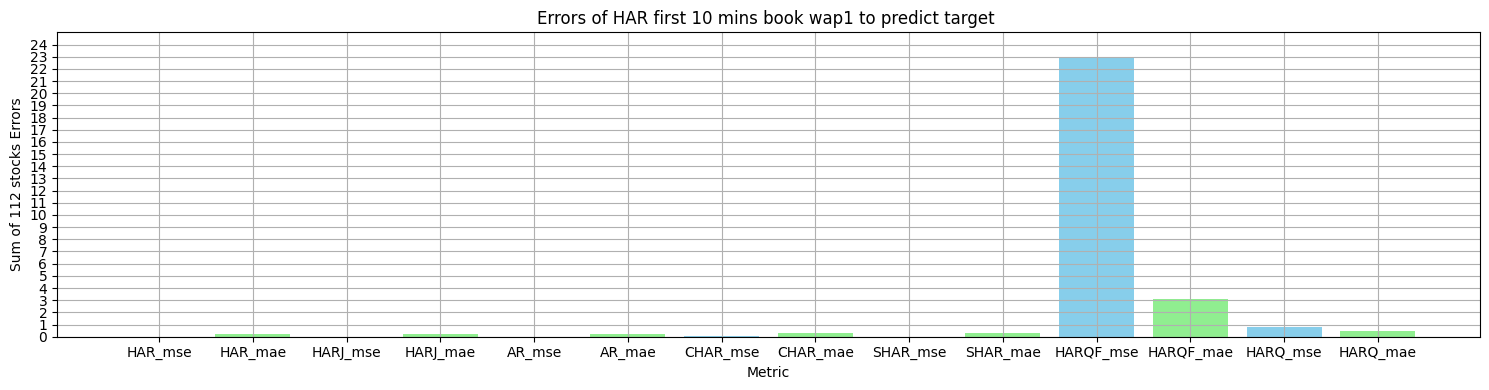

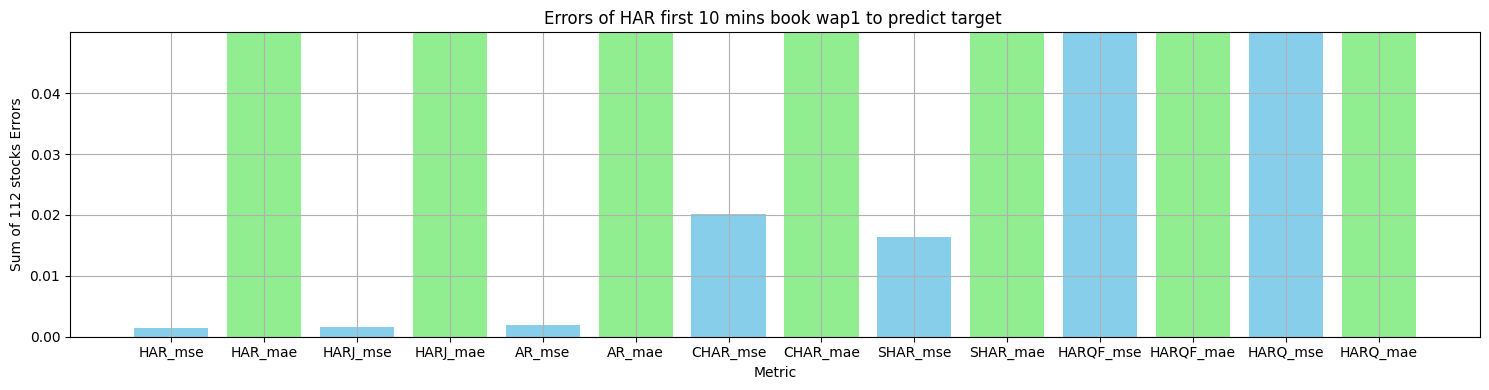

In [88]:
"""
Check which model has least error for book wap1 volatilities
"""

unique_stock_ids = HAR_book_wap1_final_predictions_errors_dict.keys()

all_st_AR_mse_sum = []
all_st_AR_mae_sum = []
all_st_HAR_mse_sum = []
all_st_HAR_mae_sum = []
all_st_HARQ_mse_sum = []
all_st_HARQ_mae_sum = []
all_st_HARQF_mse_sum = []
all_st_HARQF_mae_sum = []
all_st_CHAR_mse_sum = []
all_st_CHAR_mae_sum = []
all_st_SHAR_mse_sum = []
all_st_SHAR_mae_sum = []
all_st_HARJ_mse_sum = []
all_st_HARJ_mae_sum = []


for s in unique_stock_ids:
    #print('stock id: ',s)
    all_st_AR_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['AR_mse'] )
    all_st_AR_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['AR_mae'] )
    all_st_HAR_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HAR_mse'] )
    all_st_HAR_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HAR_mae'] )
    all_st_HARQ_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARQ_mse'] )
    all_st_HARQ_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARQ_mae'] )
    all_st_HARQF_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARQF_mse'] )
    all_st_HARQF_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARQF_mae'] )
    all_st_CHAR_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['CHAR_mse'] )
    all_st_CHAR_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['CHAR_mae'] )
    all_st_SHAR_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['SHAR_mse'] )
    all_st_SHAR_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['SHAR_mae'] )
    all_st_HARJ_mse_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARJ_mse'] )
    all_st_HARJ_mae_sum.append(HAR_book_wap1_final_predictions_errors_dict[s]['HARJ_mae'] )

all_st_AR_mse_sum = np.sum(all_st_AR_mse_sum)
all_st_AR_mae_sum = np.sum(all_st_AR_mae_sum)
all_st_HAR_mse_sum = np.sum(all_st_HAR_mse_sum)
all_st_HAR_mae_sum = np.sum(all_st_HAR_mae_sum)
all_st_HARQ_mse_sum = np.sum(all_st_HARQ_mse_sum)
all_st_HARQ_mae_sum = np.sum(all_st_HARQ_mae_sum)
all_st_HARQF_mse_sum = np.sum(all_st_HARQF_mse_sum)
all_st_HARQF_mae_sum = np.sum(all_st_HARQF_mae_sum)
all_st_CHAR_mse_sum = np.sum(all_st_CHAR_mse_sum)
all_st_CHAR_mae_sum = np.sum(all_st_CHAR_mae_sum)
all_st_SHAR_mse_sum = np.sum(all_st_SHAR_mse_sum)
all_st_SHAR_mae_sum = np.sum(all_st_SHAR_mae_sum)
all_st_HARJ_mse_sum = np.sum(all_st_HARJ_mse_sum)
all_st_HARJ_mae_sum = np.sum(all_st_HARJ_mae_sum)


fig, ax = plt.subplots(figsize=(15,4))
x = ['HAR_mse', 'HAR_mae', 'HARJ_mse','HARJ_mae', 'AR_mse','AR_mae', 'CHAR_mse','CHAR_mae', 'SHAR_mse','SHAR_mae','HARQF_mse','HARQF_mae', 'HARQ_mse','HARQ_mae']
y = [all_st_HAR_mse_sum, all_st_HAR_mae_sum, all_st_HARJ_mse_sum, all_st_HARJ_mae_sum, all_st_AR_mse_sum, all_st_AR_mae_sum, all_st_CHAR_mse_sum,\
     all_st_CHAR_mae_sum, all_st_SHAR_mse_sum, all_st_SHAR_mae_sum,all_st_HARQF_mse_sum, all_st_HARQF_mae_sum, all_st_HARQ_mse_sum, all_st_HARQ_mae_sum]
colors = ['skyblue', 'lightgreen'] * 7  # Alternating colors for each pair
ax.bar(x,y, color=colors)
ax.set_title('Errors of HAR first 10 mins book wap1 to predict target ')
ax.set_xlabel('Metric')
ax.set_ylabel('Sum of 112 stocks Errors')
ax.set_ylim([0,25])
ax.set_yticks(np.arange(0,25,1))
ax.grid(True)
fig.tight_layout()
fig.show()



fig, ax = plt.subplots(figsize=(15,4))
x = ['HAR_mse', 'HAR_mae', 'HARJ_mse','HARJ_mae', 'AR_mse','AR_mae', 'CHAR_mse','CHAR_mae', 'SHAR_mse','SHAR_mae','HARQF_mse','HARQF_mae', 'HARQ_mse','HARQ_mae']
y = [all_st_HAR_mse_sum, all_st_HAR_mae_sum, all_st_HARJ_mse_sum, all_st_HARJ_mae_sum, all_st_AR_mse_sum, all_st_AR_mae_sum, all_st_CHAR_mse_sum,\
     all_st_CHAR_mae_sum, all_st_SHAR_mse_sum, all_st_SHAR_mae_sum,all_st_HARQF_mse_sum, all_st_HARQF_mae_sum, all_st_HARQ_mse_sum, all_st_HARQ_mae_sum]
colors = ['skyblue', 'lightgreen'] * 7  # Alternating colors for each pair
ax.bar(x,y, color=colors)
ax.set_title('Errors of HAR first 10 mins book wap1 to predict target ')
ax.set_xlabel('Metric')
ax.set_ylabel('Sum of 112 stocks Errors')
ax.set_ylim([0,0.05])
ax.set_yticks(np.arange(0,0.05,0.01))
ax.grid(True)
fig.tight_layout()
fig.show()


In [89]:
#### reorder from small to large

unorder = np.array([all_st_AR_mse_sum,  all_st_HAR_mse_sum,  all_st_HARQ_mse_sum,  \
     all_st_HARQF_mse_sum,  all_st_CHAR_mse_sum,  all_st_SHAR_mse_sum,  \
     all_st_HARJ_mse_sum, ])

labels = np.array(['AR_mse', 'HAR_mse', 'HARQ_mse', 'HARQF_mse', 'CHAR_mse', 'SHAR_mse', 'HARJ_mse'])

idx = np.argsort(unorder)

unorder[idx]
print("Model with smallest to largest error for book wap1 to predict target: ",labels[idx])

Model with smallest to largest error for book wap1 to predict target:  ['HAR_mse' 'HARJ_mse' 'AR_mse' 'SHAR_mse' 'CHAR_mse' 'HARQ_mse'
 'HARQF_mse']


avg_rmspe over 112 stocks using book_wap1 first 10 mins. :
 AR        1.040901
HAR        0.90737
HARQ      9.768299
HARQF    98.218569
CHAR      2.902999
SHAR      2.555408
HARJ      0.955983
Name: avg_rmspe, dtype: object


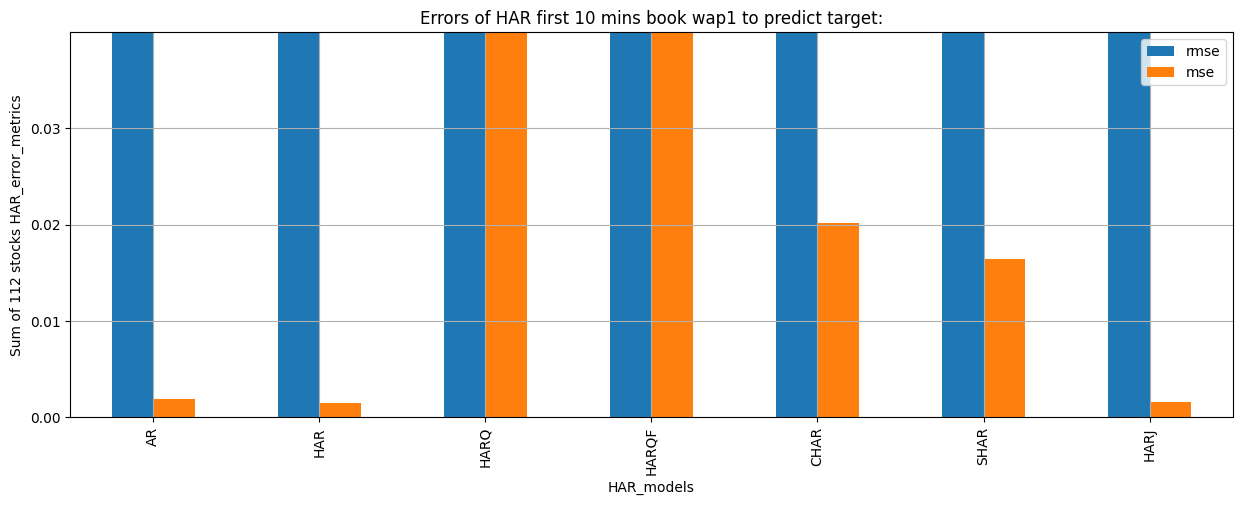

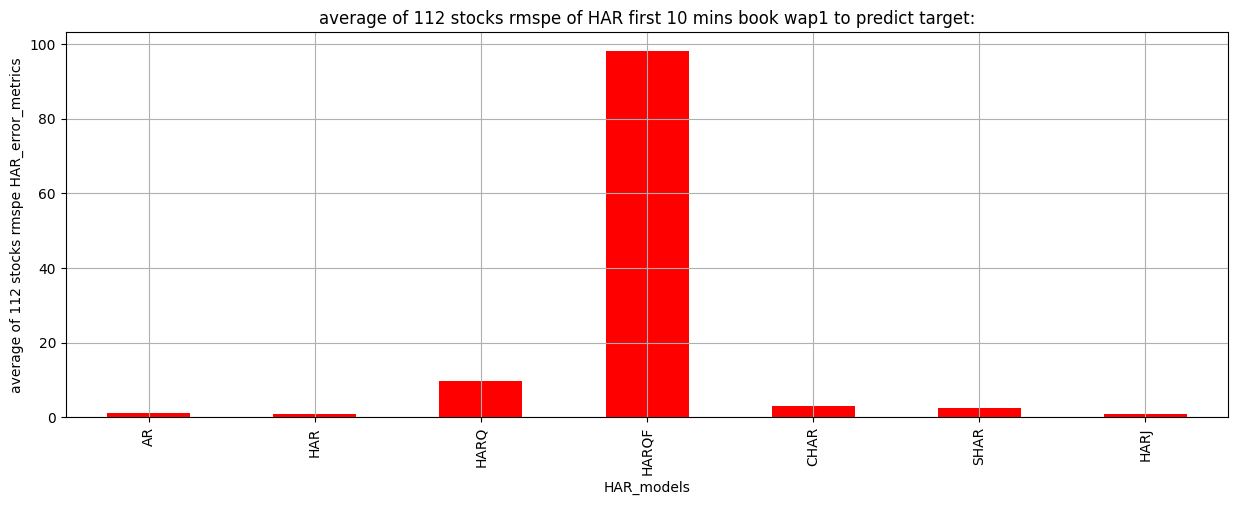

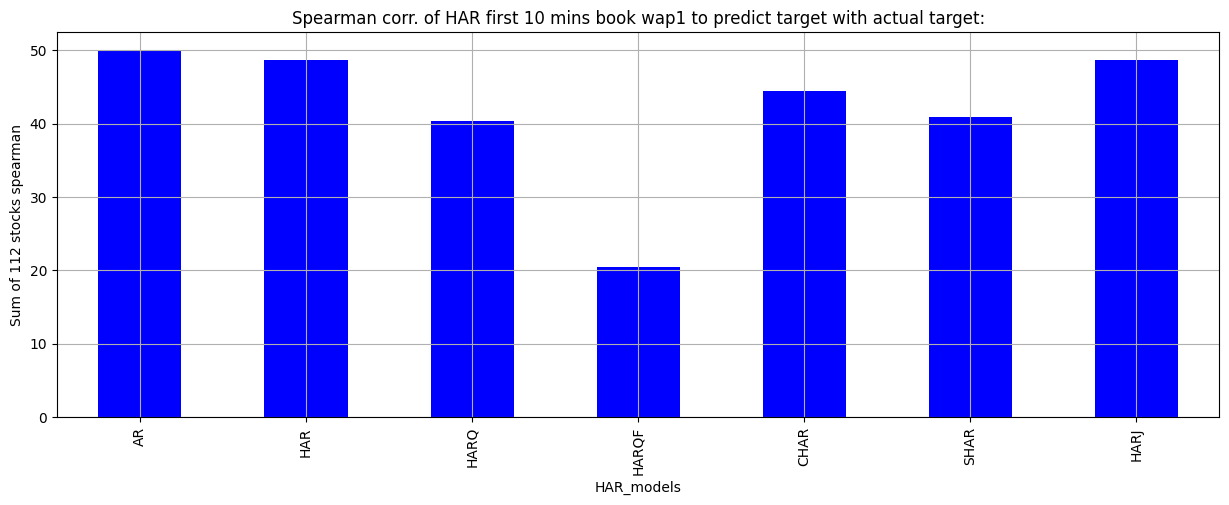

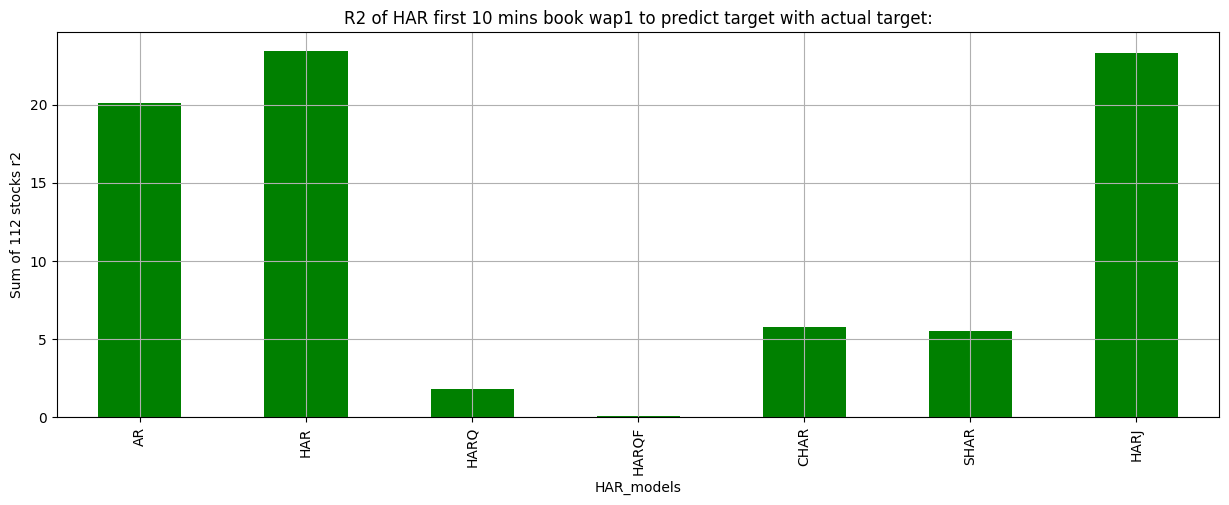

In [106]:
"""
Plot ACF and PACF for book wap1 volatilities.

"""

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true) ))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true) / y_true)))

def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def spearman(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def r2(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]**2



unique_stock_ids = HAR_book_wap1_final_predictions['st_id'].unique()

def compute_acf_pacf_n_metrics(unique_stock_ids,HAR_book_wap1_final_predictions,HAR_types):

    all_rmse = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_rmspe = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_mse = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_spearman = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}
    all_r2 = {'all_predsA':[],	'all_preds':[],	'all_predsQ':[],	'all_predsF':[],	'all_predsC':[],	'all_predsS':[],	'all_predsJ':[],}

    plt.close('all')
    tot_lags = 100
    for s in unique_stock_ids:#[0:1]: #unique_stock_ids:
        data = HAR_book_wap1_final_predictions
        data = data[data['st_id']==s]

        y_true = data.iloc[54:]['outRV'].values
        #fig,ax = plt.subplots(2,1,figsize=(30,10))
        for har_type in HAR_types:
            y_pred = data.iloc[54:][har_type].values
            # y_pred[ np.where(y_pred == np.inf) ] = 5
            # y_pred[ np.where(y_pred == -np.inf) ] = 0
            stock_residual = y_true - y_pred

            ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
            # plot_acf(stock_residual, lags=tot_lags,ax=ax[0],label=har_type,alpha=0.5)
            # plot_pacf(stock_residual, lags=tot_lags,ax=ax[1],label=har_type,alpha=0.5)
            # ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            # ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            # ax[0].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xlabel('lags')
            # ax[0].set_ylabel('ACF')
            # ax[1].set_ylabel('PACF')
            # ax[0].legend(loc='upper left')
            # ax[1].legend(loc='upper left')
            # ax[0].set_ylim([-0.2,0.2])
            # ax[1].set_ylim([-0.2,0.2])
            # ax[0].grid(True)
            # ax[1].grid(True)
            # fig.tight_layout()
            # fig.show()

            rmse_s = rmse(y_true, y_pred)
            mse_s = mse(y_true, y_pred)
            spearman_s = spearman(y_true, y_pred)
            r2_s = r2(y_true, y_pred)
            all_rmse[har_type].append(rmse_s)
            all_mse[har_type].append(mse_s)
            all_spearman[har_type].append(spearman_s)
            all_r2[har_type].append(r2_s)
            all_rmspe[har_type].append(rmspe(y_true, y_pred))
            # print('stock id: ',s)
            # print('HAR type: ',har_type)
            # print('rmse: ',rmse_s)
            # print('mse: ',mse_s)
            # print('spearman: ',spearman_s)
            # print('r2: ',r2_s)

    model_names = ['AR', 'HAR', 'HARQ', 'HARQF', 'CHAR', 'SHAR', 'HARJ']
    HAR_error_metrics = pd.DataFrame(index= model_names, columns= ["rmse", "mse", 'avg_rmspe' ])
    HAR_corr_metrics = pd.DataFrame(index= model_names, columns= [ "spearman","r2"])
    for har_type,m_name in zip(HAR_types,model_names):
        #print('\n\n\nGLOBAL Mean Metric for HAR type: ',har_type)
        sum_rmse = np.sum(all_rmse[har_type])
        sum_mse = np.sum(all_mse[har_type])
        sum_spearman = np.sum(all_spearman[har_type])
        sum_r2 = np.sum(all_r2[har_type])
        avg_rmspe = np.mean(all_rmspe[har_type])
        HAR_error_metrics.loc[m_name] = [sum_rmse, sum_mse, avg_rmspe]
        HAR_corr_metrics.loc[m_name] = [sum_spearman, sum_r2]


    fig, ax = plt.subplots(figsize=(15,5))
    HAR_error_metrics[['rmse','mse']].plot.bar(ax=ax)
    ax.set_title('Errors of HAR first 10 mins book wap1 to predict target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks HAR_error_metrics')
    ax.set_ylim([0,0.04])
    ax.set_yticks(np.arange(0,0.04,0.01))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()


    fig, ax = plt.subplots(figsize=(15,5))
    HAR_error_metrics['avg_rmspe'].plot.bar(ax=ax,color=['red'])
    ax.set_title('average of 112 stocks rmspe of HAR first 10 mins book wap1 to predict target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('average of 112 stocks rmspe HAR_error_metrics')
    # ax.set_ylim([0,0.04])
    # ax.set_yticks(np.arange(0,0.04,0.01))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    print("avg_rmspe over 112 stocks using book_wap1 first 10 mins. :\n", HAR_error_metrics['avg_rmspe'])

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics['spearman'].plot.bar(ax=ax,color=['blue'])
    ax.set_title('Spearman corr. of HAR first 10 mins book wap1 to predict target with actual target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks spearman')
    # ax.set_ylim([43,67])
    # ax.set_yticks(np.arange(43,67,  1))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics["r2"].plot.bar(ax=ax,color=['green'])
    ax.set_title('R2 of HAR first 10 mins book wap1 to predict target with actual target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks r2')
    # ax.set_ylim([7,9])
    # ax.set_yticks(np.arange(7,9,0.2))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    return

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features/final_features_for_xgboost')
HAR_book_wap1_all_predictions = pd.read_parquet('HAR_book_wap1_all_predictions.parquet')

HAR_types = ['all_predsA',	'all_preds',	'all_predsQ',	'all_predsF',	'all_predsC',	'all_predsS',	'all_predsJ']
#HAR_types = ['all_predsQ']
##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
compute_acf_pacf_n_metrics(unique_stock_ids,HAR_book_wap1_all_predictions,HAR_types)


In [78]:
"""
Evaluate trade HAR training model

concatenate the intial time ids with the rest of time ids and fill missing values to crease final all HAR features


"""

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_trade_price_final_predictions_init_time_ids =  pd.read_parquet('HAR_trade_price_final_predictions_init_time_ids.parquet')
HAR_trade_price_final_predictions_errors_dict_init_time_ids = pickle.load(open('HAR_trade_price_final_predictions_errors_dict_init_time_ids.pkl','rb'))

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features')
HAR_trade_price_final_predictions =  pd.read_parquet('HAR_trade_price_final_predictions.parquet')
HAR_trade_price_final_predictions_errors_dict = pickle.load(open('HAR_trade_price_final_predictions_errors_dict.pkl','rb'))

HAR_trade_price_all_predictions = pd.DataFrame(index= HAR_trade_price_final_predictions.index, columns= ["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"])
HAR_types = ["tr_outRV","tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"]


for har_type in HAR_types:
    all_stock_vals = np.array([])
    for s in unique_stock_ids:
        first = HAR_trade_price_final_predictions_init_time_ids[HAR_trade_price_final_predictions_init_time_ids['st_id'] == s].iloc[:54][har_type].values
        second = HAR_trade_price_final_predictions[HAR_trade_price_final_predictions['st_id'] == s][har_type].iloc[54:].values
        last = np.concatenate((first, second))
        all_stock_vals = np.concatenate((all_stock_vals, last))
    HAR_trade_price_all_predictions[har_type] = all_stock_vals
    HAR_trade_price_all_predictions[har_type].ffill(inplace=True)
    HAR_trade_price_all_predictions[har_type].bfill(inplace=True)

HAR_trade_price_all_predictions['st_id'] = HAR_trade_price_final_predictions['st_id']
HAR_trade_price_all_predictions['time_id'] = HAR_trade_price_final_predictions['time_id']

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features/final_features_for_xgboost')
HAR_trade_price_all_predictions.to_parquet('HAR_trade_price_all_predictions.parquet')
trade_HAR_vol_estimates_full_df.to_parquet('trade_HAR_vol_estimates_full_df.parquet') # this contains RV, RQ, BPV , RSV+, RSV-


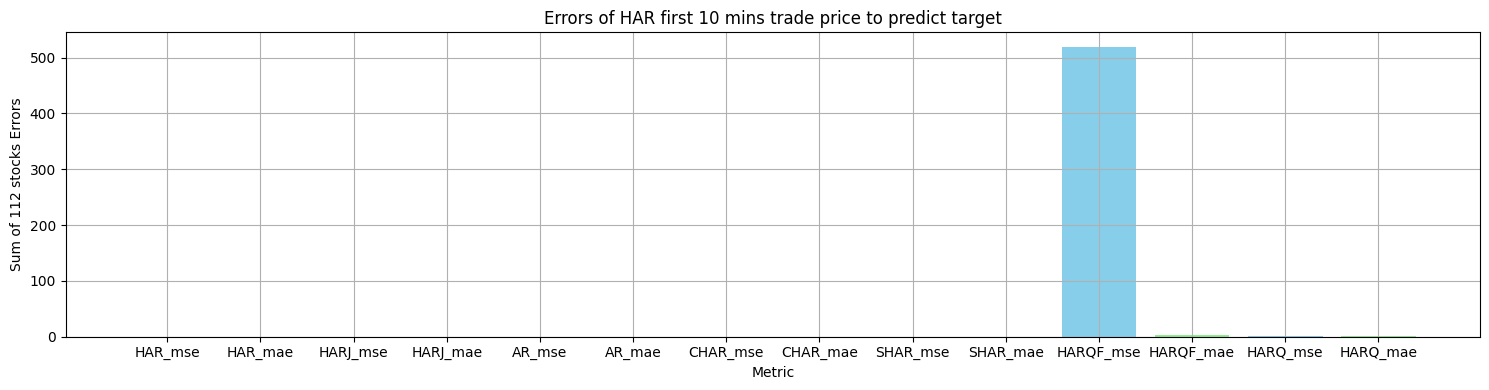

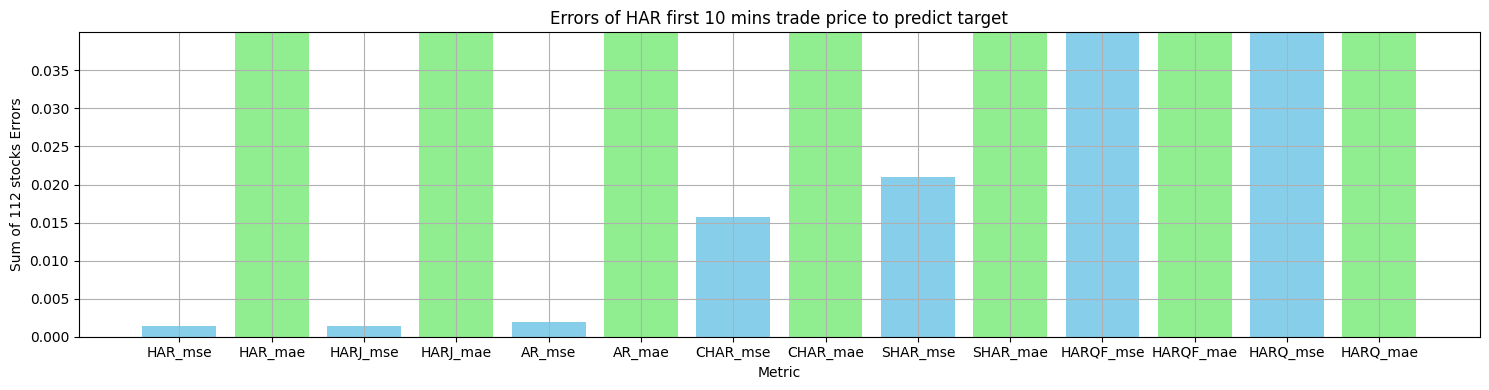

In [93]:
"""
Check which model has least error for trade price volatilities
"""





unique_stock_ids = HAR_trade_price_final_predictions_errors_dict.keys()

all_st_AR_mse_sum = []
all_st_AR_mae_sum = []
all_st_HAR_mse_sum = []
all_st_HAR_mae_sum = []
all_st_HARQ_mse_sum = []
all_st_HARQ_mae_sum = []
all_st_HARQF_mse_sum = []
all_st_HARQF_mae_sum = []
all_st_CHAR_mse_sum = []
all_st_CHAR_mae_sum = []
all_st_SHAR_mse_sum = []
all_st_SHAR_mae_sum = []
all_st_HARJ_mse_sum = []
all_st_HARJ_mae_sum = []


for s in unique_stock_ids:
    #print('stock id: ',s)
    all_st_AR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['AR_mse'] )
    all_st_AR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['AR_mae'] )
    all_st_HAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HAR_mse'] )
    all_st_HAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HAR_mae'] )
    all_st_HARQ_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQ_mse'] )
    all_st_HARQ_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQ_mae'] )
    all_st_HARQF_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQF_mse'] )
    all_st_HARQF_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARQF_mae'] )
    all_st_CHAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['CHAR_mse'] )
    all_st_CHAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['CHAR_mae'] )
    all_st_SHAR_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['SHAR_mse'] )
    all_st_SHAR_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['SHAR_mae'] )
    all_st_HARJ_mse_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARJ_mse'] )
    all_st_HARJ_mae_sum.append(HAR_trade_price_final_predictions_errors_dict[s]['HARJ_mae'] )

all_st_AR_mse_sum = np.sum(all_st_AR_mse_sum)
all_st_AR_mae_sum = np.sum(all_st_AR_mae_sum)
all_st_HAR_mse_sum = np.sum(all_st_HAR_mse_sum)
all_st_HAR_mae_sum = np.sum(all_st_HAR_mae_sum)
all_st_HARQ_mse_sum = np.sum(all_st_HARQ_mse_sum)
all_st_HARQ_mae_sum = np.sum(all_st_HARQ_mae_sum)
all_st_HARQF_mse_sum = np.sum(all_st_HARQF_mse_sum)
all_st_HARQF_mae_sum = np.sum(all_st_HARQF_mae_sum)
all_st_CHAR_mse_sum = np.sum(all_st_CHAR_mse_sum)
all_st_CHAR_mae_sum = np.sum(all_st_CHAR_mae_sum)
all_st_SHAR_mse_sum = np.sum(all_st_SHAR_mse_sum)
all_st_SHAR_mae_sum = np.sum(all_st_SHAR_mae_sum)
all_st_HARJ_mse_sum = np.sum(all_st_HARJ_mse_sum)
all_st_HARJ_mae_sum = np.sum(all_st_HARJ_mae_sum)


fig, ax = plt.subplots(figsize=(15,4))
x = ['HAR_mse', 'HAR_mae', 'HARJ_mse','HARJ_mae', 'AR_mse','AR_mae', 'CHAR_mse','CHAR_mae', 'SHAR_mse','SHAR_mae','HARQF_mse','HARQF_mae', 'HARQ_mse','HARQ_mae']
y = [all_st_HAR_mse_sum, all_st_HAR_mae_sum, all_st_HARJ_mse_sum, all_st_HARJ_mae_sum, all_st_AR_mse_sum, all_st_AR_mae_sum, all_st_CHAR_mse_sum,\
     all_st_CHAR_mae_sum, all_st_SHAR_mse_sum, all_st_SHAR_mae_sum,all_st_HARQF_mse_sum, all_st_HARQF_mae_sum, all_st_HARQ_mse_sum, all_st_HARQ_mae_sum]
colors = ['skyblue', 'lightgreen'] * 7  # Alternating colors for each pair
ax.bar(x,y, color=colors)
ax.set_title('Errors of HAR first 10 mins trade price to predict target')
ax.set_xlabel('Metric')
ax.set_ylabel('Sum of 112 stocks Errors')
# ax.set_ylim([0,0.04])
# ax.set_yticks(np.arange(0,0.04,0.005))
ax.grid(True)
fig.tight_layout()
fig.show()


fig, ax = plt.subplots(figsize=(15,4))
x = ['HAR_mse', 'HAR_mae', 'HARJ_mse','HARJ_mae', 'AR_mse','AR_mae', 'CHAR_mse','CHAR_mae', 'SHAR_mse','SHAR_mae','HARQF_mse','HARQF_mae', 'HARQ_mse','HARQ_mae']
y = [all_st_HAR_mse_sum, all_st_HAR_mae_sum, all_st_HARJ_mse_sum, all_st_HARJ_mae_sum, all_st_AR_mse_sum, all_st_AR_mae_sum, all_st_CHAR_mse_sum,\
     all_st_CHAR_mae_sum, all_st_SHAR_mse_sum, all_st_SHAR_mae_sum,all_st_HARQF_mse_sum, all_st_HARQF_mae_sum, all_st_HARQ_mse_sum, all_st_HARQ_mae_sum]
colors = ['skyblue', 'lightgreen'] * 7  # Alternating colors for each pair
ax.bar(x,y, color=colors)
ax.set_title('Errors of HAR first 10 mins trade price to predict target')
ax.set_xlabel('Metric')
ax.set_ylabel('Sum of 112 stocks Errors')
ax.set_ylim([0,0.04])
ax.set_yticks(np.arange(0,0.04,0.005))
ax.grid(True)
fig.tight_layout()
fig.show()


In [94]:
#### reorder from small to large

unorder = np.array([all_st_AR_mse_sum,  all_st_HAR_mse_sum,  all_st_HARQ_mse_sum,  \
     all_st_HARQF_mse_sum,  all_st_CHAR_mse_sum,  all_st_SHAR_mse_sum,  \
     all_st_HARJ_mse_sum, ])

labels = np.array(['AR_mse', 'HAR_mse', 'HARQ_mse', 'HARQF_mse', 'CHAR_mse', 'SHAR_mse', 'HARJ_mse'])

idx = np.argsort(unorder)

unorder[idx]
print("Model with smallest to largest error for trade price to predict target: ",labels[idx])

Model with smallest to largest error for trade price to predict target:  ['HAR_mse' 'HARJ_mse' 'AR_mse' 'CHAR_mse' 'SHAR_mse' 'HARQ_mse'
 'HARQF_mse']


avg_rmspe over 112 stocks using trade price first 10 mins. :
 AR         1.037026
HAR        0.989844
HARQ      22.276021
HARQF    189.392092
CHAR        8.09747
SHAR       5.788804
HARJ       0.990217
Name: avg_rmspe, dtype: object


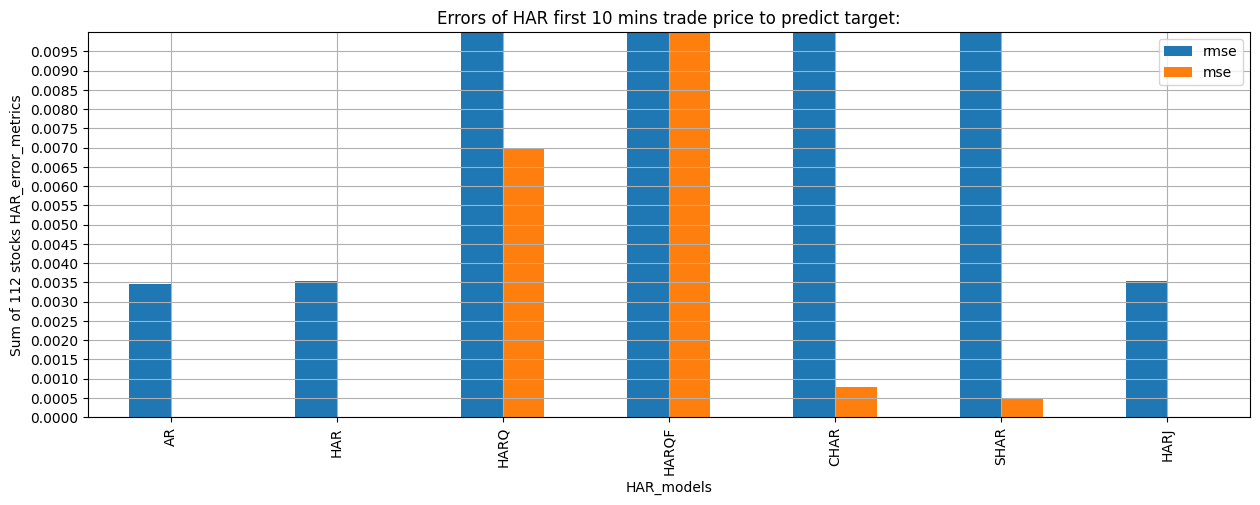

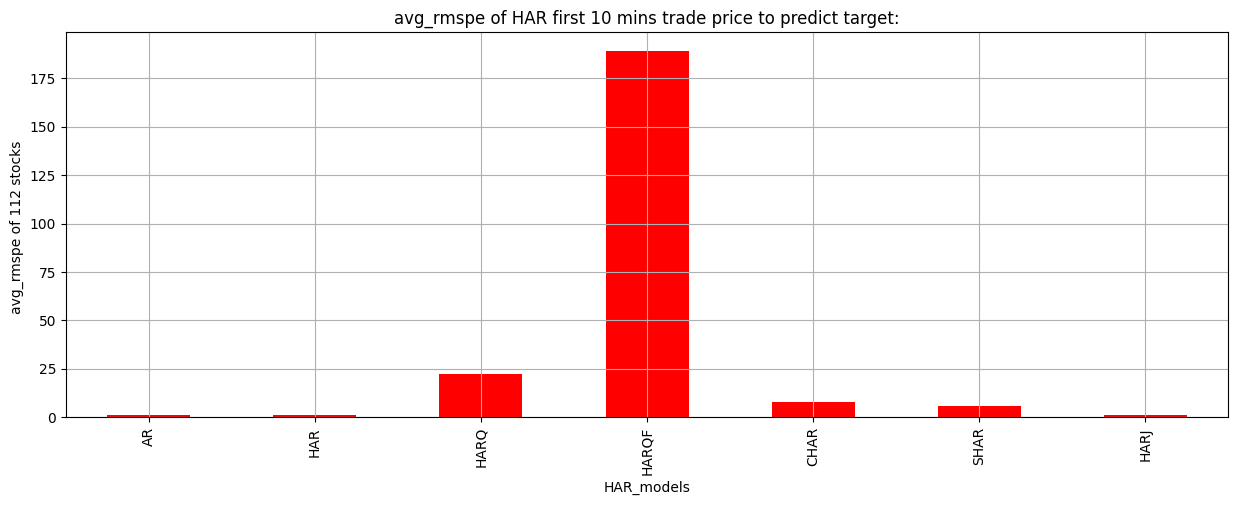

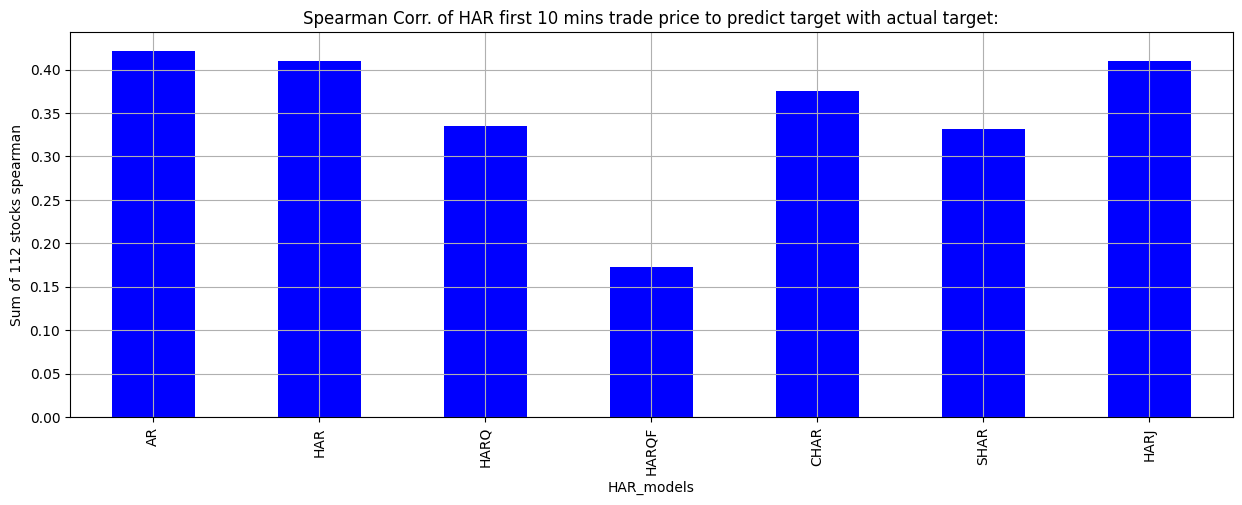

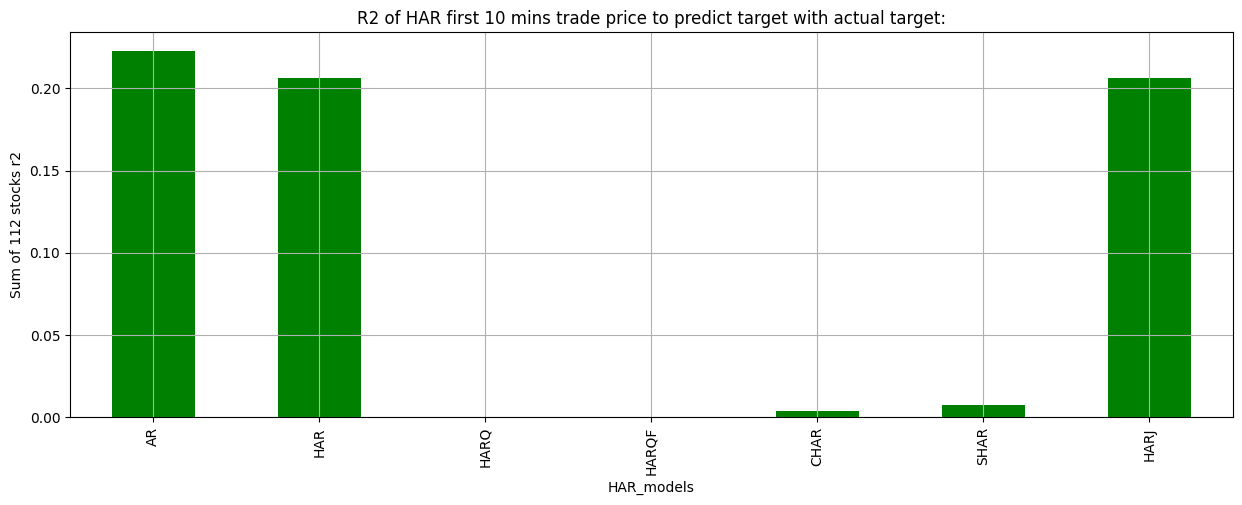

In [112]:

"""
Plot ACF and PACF for trade price volatilities.

"""

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true) ))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_pred - y_true) / y_true)))

def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

def spearman(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def r2(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]**2


unique_stock_ids = HAR_trade_price_all_predictions['st_id'].unique()

def compute_acf_pacf_n_metrics(unique_stock_ids,HAR_trade_price_all_predictions,HAR_types):

    all_rmse = {'tr_all_predsA':[],	'tr_all_preds':[],	'tr_all_predsQ':[],	'tr_all_predsF':[],	'tr_all_predsC':[],	'tr_all_predsS':[], 'tr_all_predsJ':[]}
    all_rmspe = {'tr_all_predsA':[],	'tr_all_preds':[],	'tr_all_predsQ':[],	'tr_all_predsF':[],	'tr_all_predsC':[],	'tr_all_predsS':[], 'tr_all_predsJ':[]}
    all_mse = {'tr_all_predsA':[],	'tr_all_preds':[],	'tr_all_predsQ':[],	'tr_all_predsF':[],	'tr_all_predsC':[],	'tr_all_predsS':[], 'tr_all_predsJ':[]}
    all_spearman = {'tr_all_predsA':[],	'tr_all_preds':[],	'tr_all_predsQ':[],	'tr_all_predsF':[],	'tr_all_predsC':[],	'tr_all_predsS':[], 'tr_all_predsJ':[]}
    all_r2 = {'tr_all_predsA':[],	'tr_all_preds':[],	'tr_all_predsQ':[],	'tr_all_predsF':[],	'tr_all_predsC':[],	'tr_all_predsS':[], 'tr_all_predsJ':[]}

    plt.close('all')
    tot_lags = 100
    for s in unique_stock_ids[0:1]: #unique_stock_ids:
        data = HAR_trade_price_all_predictions
        data = data[data['st_id']==s]

        y_true = data.iloc[54:]['tr_outRV'].values
        #fig,ax = plt.subplots(2,1,figsize=(30,10))
        for har_type in HAR_types:
            y_pred = data.iloc[54:][har_type].values
            # y_pred[ np.where(y_pred == np.inf) ] = 5
            # y_pred[ np.where(y_pred == -np.inf) ] = 0
            stock_residual = y_true - y_pred

            # ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
            # plot_acf(stock_residual, lags=tot_lags,ax=ax[0],label=har_type,alpha=0.5)
            # plot_pacf(stock_residual, lags=tot_lags,ax=ax[1],label=har_type,alpha=0.5)
            # ax[0].set_title(f'Autocorrelation of stock {s} Residuals on train set')
            # ax[1].set_title(f'Partial Autocorrelation of stock {s} Residuals on train set')
            # ax[0].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xticks(range(0,tot_lags,5))
            # ax[1].set_xlabel('lags')
            # ax[0].set_ylabel('ACF')
            # ax[1].set_ylabel('PACF')
            # ax[0].legend(loc='upper left')
            # ax[1].legend(loc='upper left')
            # ax[0].set_ylim([-0.2,0.2])
            # ax[1].set_ylim([-0.2,0.2])
            # ax[0].grid(True)
            # ax[1].grid(True)
            # fig.tight_layout()
            # fig.show()

            rmse_s = rmse(y_true, y_pred)
            mse_s = mse(y_true, y_pred)
            spearman_s = spearman(y_true, y_pred)
            r2_s = r2(y_true, y_pred)
            all_rmse[har_type].append(rmse_s)
            all_mse[har_type].append(mse_s)
            all_spearman[har_type].append(spearman_s)
            all_r2[har_type].append(r2_s)
            all_rmspe[har_type].append(rmspe(y_true, y_pred))
            # print('stock id: ',s)
            # print('HAR type: ',har_type)
            # print('rmse: ',rmse_s)
            # print('mse: ',mse_s)
            # print('spearman: ',spearman_s)
            # print('r2: ',r2_s)

    model_names = ['AR', 'HAR', 'HARQ', 'HARQF', 'CHAR', 'SHAR', 'HARJ']
    HAR_error_metrics = pd.DataFrame(index= model_names, columns= ["rmse", "mse", "avg_rmspe" ])
    HAR_corr_metrics = pd.DataFrame(index= model_names, columns= [ "spearman","r2"])
    for har_type,m_name in zip(HAR_types,model_names):
        #print('\n\n\nGLOBAL Mean Metric for HAR type: ',har_type)
        sum_rmse = np.sum(all_rmse[har_type])
        sum_mse = np.sum(all_mse[har_type])
        sum_spearman = np.sum(all_spearman[har_type])
        sum_r2 = np.sum(all_r2[har_type])
        avg_rmspe = np.mean(all_rmspe[har_type])
        HAR_error_metrics.loc[m_name] = [sum_rmse, sum_mse, avg_rmspe]
        HAR_corr_metrics.loc[m_name] = [sum_spearman, sum_r2]

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_error_metrics[["rmse", "mse"]].plot.bar(ax=ax)
    ax.set_title('Errors of HAR first 10 mins trade price to predict target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks HAR_error_metrics')
    ax.set_ylim([0,0.01])
    ax.set_yticks(np.arange(0,0.01,0.0005))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()


    fig, ax = plt.subplots(figsize=(15,5))
    HAR_error_metrics['avg_rmspe'].plot.bar(ax=ax,color=['red'])
    ax.set_title('avg_rmspe of HAR first 10 mins trade price to predict target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('avg_rmspe of 112 stocks ')
    # ax.set_ylim([0.32,0.37])
    # ax.set_yticks(np.arange(0.32,0.37,0.01))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    print("avg_rmspe over 112 stocks using trade price first 10 mins. :\n", HAR_error_metrics['avg_rmspe'])

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics['spearman'].plot.bar(ax=ax,color=['blue'])
    ax.set_title('Spearman Corr. of HAR first 10 mins trade price to predict target with actual target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks spearman')
    # ax.set_ylim([0.32,0.37])
    # ax.set_yticks(np.arange(0.32,0.37,0.01))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    fig, ax = plt.subplots(figsize=(15,5))
    HAR_corr_metrics["r2"].plot.bar(ax=ax,color=['green'])
    ax.set_title('R2 of HAR first 10 mins trade price to predict target with actual target:')
    ax.set_xlabel('HAR_models')
    ax.set_ylabel('Sum of 112 stocks r2')
    # ax.set_ylim([0.011,0.013])
    # ax.set_yticks(np.arange(00.011,0.013,0.001))
    ax.grid(True)
    #fig.tight_layout()
    fig.show()

    return

os.chdir('/content/drive/MyDrive/optiver_real_vol/Datasets/HAR_features/final_features_for_xgboost')
HAR_trade_price_all_predictions = pd.read_parquet('HAR_trade_price_all_predictions.parquet')

HAR_types = ["tr_all_predsA", "tr_all_preds", "tr_all_predsQ", "tr_all_predsF", "tr_all_predsC", "tr_all_predsS", "tr_all_predsJ"]
#HAR_types = ['all_predsQ']
##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
compute_acf_pacf_n_metrics(unique_stock_ids,HAR_trade_price_all_predictions,HAR_types)



In [ ]:
"""
Statistical significance test of model parameters
"""

# import pandas as pd
# import numpy as np
# from linearmodels import PanelOLS
# from linearmodels import IV2SLS
# from linearmodels.iv.results import IVModelComparison
# from statsmodels.tools.tools import add_constant
# from arch.bootstrap import IIDBootstrap
# from linearmodels.iv import IV2SLS



# def data_set_scalar(DataSet, scalar=100000):
#     DataSet.iloc[:, 1:] *= scalar
#     return DataSet

# def beta_table(forecast):
#     models = ['modelA', 'model', 'modelQ', 'modelF', 'modelC', 'modelS', 'modelJ']
#     robust_t_test = {}

#     for model in models:
#         robust_std_errs = coeftest(forecast[3][model], vcov=vcovHC(forecast[3][model], type="HC1"))
#         robust_t_test[model] = robust_std_errs

#     robust_t_test_matrix = np.vstack(list(robust_t_test.values()))[:, :2]
#     robust_t_test_table = np.full((10, 7), np.nan)
#     colnames = ["AR(3)", "HAR", "HARQ", "HARQ-F", "CHAR", "SHAR", "HAR-J"]
#     rownames = ["b0", "b1", "b2", "b3", "b1Q", "b2Q", "b3Q", "b1+", "b1-", "bJ"]

#     # Fill the table with coefficients and standard errors
#     c_ar = np.arange(len(forecast[3]['modelA'].params))
#     robust_t_test_table[c_ar, 0] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_ar]

#     l_har = np.arange(len(forecast[3]['model'].params))
#     c_har = len(c_ar) + l_har
#     robust_t_test_table[l_har, 1] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_har]

#     l_harq = np.arange(len(forecast[3]['modelQ'].params))
#     c_harq = len(c_har) + l_harq + 4
#     robust_t_test_table[l_harq, 2] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harq]

#     l_harqf = np.arange(len(forecast[3]['modelF'].params))
#     c_harqf = len(c_harq) + l_harqf + 8
#     robust_t_test_table[l_harqf, 3] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harqf]

#     l_char = np.arange(len(forecast[3]['modelC'].params))
#     c_char = len(l_harqf) + l_char + 13
#     robust_t_test_table[l_char, 4] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_char]

#     l_shar = np.arange(len(forecast[3]['modelS'].params))
#     c_shar = len(l_char) + l_shar + 20
#     robust_t_test_table[[0, 2, 3, 7, 8], 5] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_shar]

#     l_harj = np.arange(len(forecast[3]['modelJ'].params))
#     c_harj = len(l_shar) + l_harj + 24
#     robust_t_test_table[[0, 1, 2, 3, 9], 6] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harj]

#     # Append R^squareds to table
#     rsquareds = np.vstack([forecast[4].iloc[0, :], forecast[4].iloc[1, :]])
#     robust_t_test_table_w_rsquareds = np.vstack([robust_t_test_table, [np.nan]*7, rsquareds])
#     robust_t_test_table_w_rsquareds[11, :] = ["R^2", "Adj.R^2"] + [""] * 5

#     # Exporting Results
#     pd.DataFrame(robust_t_test_table_w_rsquareds, index=rownames + ["", ""], columns=colnames).to_excel("Results/Betas_w_all_rsquareds.xlsx", index=True, header=True)

#     return robust_t_test_table_w_rsquareds

# # Example usage
# data = pd.read_csv("data.csv")  # Replace "data.csv" with your actual data file
# RV_df = estimator(data)
# RV_df_scaled = data_set_scalar(RV_df)

In [ ]:
"""
# Plot ACF and PACF of RV to identify significant lags

# We don't need this because we just take lags 1 to 3 at max by default.
# """

# def compute_acf_pacf(unique_stock_ids,all_stock_train_pred_df,start_time_id_index,end_time_id_index):
#     ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
#     plt.close('all')
#     for s in unique_stock_ids[0:10]:
#         fig,ax = plt.subplots(2,1,figsize=(30,6))
#         stock_rv = all_stock_train_pred_df[all_stock_train_pred_df['st_id']==s].iloc[start_time_id_index:end_time_id_index]['RV']
#         #plot_acf(stock_rv, lags=50,ax=ax[0])
#         plot_pacf(stock_rv, lags=50,ax=ax[1])
#         #ax[0].set_title(f'Autocorrelation of stock {s} Real. Vol. ')
#         ax[1].set_title(f'Partial Autocorrelation of stock {s}  Real. Vol.')
#         #ax[0].set_xticks(range(0,50,5))
#         ax[1].set_xticks(range(0,50,5))
#         ax[1].set_xlabel('lags')
#         #ax[0].set_ylabel('ACF')
#         ax[1].set_ylabel('PACF')
#         #ax[0].grid(True)
#         ax[1].grid(True)
#         fig.show()
#     return

# unique_stock_ids = book_wap1_HAR_vol_estimates_full_df['st_id'].unique()

# ##### Autocorrelation and Partial Autocorrelation Plot EVERY individual stock
# start_time_id_index = 0
# end_time_id_index = 100
# compute_acf_pacf(unique_stock_ids,book_wap1_HAR_vol_estimates_full_df,start_time_id_index,end_time_id_index)

In [ ]:
"""
Copy of FULL original python code for reference

"""


# def data_set_scalar(DataSet, scalar=100000):
#     DataSet.iloc[:, 1:] *= scalar
#     return DataSet

# def HAR(data, out_sample=96, plot_scalar=1, extra_plots=False):
#     RV = data['RV']
#     RQ = data['RQ']
#     BPV = data['BPV']
#     RV_p = data['RV_plus']
#     RV_m = data['RV_minus']

#     nobs = len(RV)
#     in_sample = nobs - out_sample

#     outRV = RV[in_sample:]
#     lag = 22  # 22 days lag is equivalent to one month of trading days lag,

#     all_predsA = np.zeros(out_sample)
#     all_preds = np.zeros(out_sample)
#     all_predsQ = np.zeros(out_sample)
#     all_predsF = np.zeros(out_sample)
#     all_predsC = np.zeros(out_sample)
#     all_predsS = np.zeros(out_sample)
#     all_predsJ = np.zeros(out_sample)

#     all_betasA = np.zeros((out_sample, 4))
#     all_betas = np.zeros((out_sample, 4))
#     all_betasQ = np.zeros((out_sample, 5))
#     all_betasF = np.zeros((out_sample, 7))
#     all_betasC = np.zeros((out_sample, 4))
#     all_betasS = np.zeros((out_sample, 5))
#     all_betasJ = np.zeros((out_sample, 5))

#     for t in range(out_sample):
#         # Estimation
#         y = RV[(lag + t + 1):(in_sample + t)]
#         XA = np.zeros((in_sample - lag, 3))
#         X = np.zeros((in_sample - lag, 3))
#         XQ = np.zeros((in_sample - lag, 4))
#         XF = np.zeros((in_sample - lag, 6))
#         XC = np.zeros((in_sample - lag, 3))
#         XS = np.zeros((in_sample - lag, 4))
#         XJ = np.zeros((in_sample - lag, 4))

#         for i in range(in_sample - lag):
#             # AR(3) # three days back
#             print(RV[i - 1 + lag + t])
#             XA[i, 0] = RV[i - 1 + lag + t]
#             XA[i, 1] = RV[i - 2 + lag + t]
#             XA[i, 2] = RV[i - 3 + lag + t]

#             # HAR
#             X[i, 0] = RV[i - 1 + lag + t]
#             X[i, 1] = (1 / 5) * sum(RV[i - 5 + lag + t:i + lag + t])
#             X[i, 2] = (1 / 22) * sum(RV[i - 22 + lag + t:i + lag + t])

#             # HARQ
#             XQ[i, 0] = RV[i - 1 + lag + t]
#             XQ[i, 1] = (1 / 5) * sum(RV[i - 5 + lag + t:i + lag + t])
#             XQ[i, 2] = (1 / 22) * sum(RV[i - 22 + lag + t:i + lag + t])
#             XQ[i, 3] = (RQ[i - 1 + lag + t] ** (1 / 2)) * RV[i - 1 + lag + t]

#             # HARQ-F
#             XF[i, 0] = RV[i - 1 + lag + t]
#             XF[i, 1] = (1 / 5) * sum(RV[i - 5 + lag + t:i + lag + t])
#             XF[i, 2] = (1 / 22) * sum(RV[i - 22 + lag + t:i + lag + t])
#             XF[i, 3] = (RQ[i - 1 + lag + t] ** (1 / 2)) * RV[i - 1 + lag + t]
#             XF[i, 4] = (((1 / 5) * sum(RQ[i - 5 + lag + t:i + lag + t])) ** (1 / 2)) * (
#                     ((1 / 5) * sum(RV[i - 5 + lag + t:i + lag + t])) ** (1 / 2))
#             XF[i, 5] = (((1 / 22) * sum(RQ[i - 22 + lag + t:i + lag + t])) ** (1 / 2)) * (
#                     ((1 / 22) * sum(RV[i - 22 + lag + t:i + lag + t])) ** (1 / 2))

#             # CHAR
#             XC[i, 0] = BPV[i - 1 + lag + t]
#             XC[i, 1] = (1 / 5) * sum(BPV[i - 5 + lag + t:i + lag + t])
#             XC[i, 2] = (1 / 22) * sum(BPV[i - 22 + lag + t:i + lag + t])

#             # HARS
#             XS[i, 0] = RV_p[i - 1 + lag + t]
#             XS[i, 1] = (1 / 5) * sum(RV_p[i - 5 + lag + t:i + lag + t])
#             XS[i, 2] = (1 / 22) * sum(RV_p[i - 22 + lag + t:i + lag + t])
#             XS[i, 3] = (RV_m[i - 1 + lag + t] ** (1 / 2)) * RV_p[i - 1 + lag + t]

#             # HARQ-J
#             XJ[i, 0] = RV[i - 1 + lag + t]
#             XJ[i, 1] = (1 / 5) * sum(RV[i - 5 + lag + t:i + lag + t])
#             XJ[i, 2] = (1 / 22) * sum(RV[i - 22 + lag + t:i + lag + t])
#             XJ[i, 3] = (RQ[i - 1 + lag + t] ** (1 / 2)) * RV[i - 1 + lag + t]
#             XJ[i, 4] = (RV_m[i - 1 + lag + t] ** (1 / 2)) * RV_p[i - 1 + lag + t]

#         # AR(3)
#         betaA = np.linalg.inv(XA.T @ XA) @ XA.T @ y
#         all_betasA[t] = betaA

#         # HAR
#         beta = np.linalg.inv(X.T @ X) @ X.T @ y
#         all_betas[t] = beta

#         # HARQ
#         betaQ = np.linalg.inv(XQ.T @ XQ) @ XQ.T @ y
#         all_betasQ[t] = betaQ

#         # HARQ-F
#         betaF = np.linalg.inv(XF.T @ XF) @ XF.T @ y
#         all_betasF[t] = betaF

#         # CHAR
#         betaC = np.linalg.inv(XC.T @ XC) @ XC.T @ y
#         all_betasC[t] = betaC

#         # HARS
#         betaS = np.linalg.inv(XS.T @ XS) @ XS.T @ y
#         all_betasS[t] = betaS

#         # HARQ-J
#         betaJ = np.linalg.inv(XJ.T @ XJ) @ XJ.T @ y
#         all_betasJ[t] = betaJ

#         all_predsA[t] = XA[-1, :] @ betaA
#         all_preds[t] = X[-1, :] @ beta
#         all_predsQ[t] = XQ[-1, :] @ betaQ
#         all_predsF[t] = XF[-1, :] @ betaF
#         all_predsC[t] = XC[-1, :] @ betaC
#         all_predsS[t] = XS[-1, :] @ betaS
#         all_predsJ[t] = XJ[-1, :] @ betaJ

#     if extra_plots:
#         fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#         ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

#         ax1.plot(all_predsA, label='AR(3)')
#         ax1.plot(outRV, label='RV_true')
#         ax1.legend()

#         ax2.plot(all_preds, label='HAR')
#         ax2.plot(outRV, label='RV_true')
#         ax2.legend()

#         ax3.plot(all_predsQ, label='HARQ')
#         ax3.plot(outRV, label='RV_true')
#         ax3.legend()

#         ax4.plot(all_predsF, label='HARQ-F')
#         ax4.plot(outRV, label='RV_true')
#         ax4.legend()

#         ax5.plot(all_predsC, label='CHAR')
#         ax5.plot(outRV, label='RV_true')
#         ax5.legend()

#         ax6.plot(all_predsS, label='HARS')
#         ax6.plot(outRV, label='RV_true')
#         ax6.legend()

#         ax7.plot(all_predsJ, label='HARQ-J')
#         ax7.plot(outRV, label='RV_true')
#         ax7.legend()

#         ax8.plot(all_predsA - outRV, label='AR(3)')
#         ax8.legend()

#         ax9.plot(all_preds - outRV, label='HAR')
#         ax9.legend()

#         plt.show()

#     return all_preds, all_predsQ, all_predsF, all_predsC, all_predsS, all_predsJ


# data = pd.read_csv("data.csv")  # Replace "data.csv" with your actual data file
# RV_df = estimator(data)
# predictions, predictions_Q, predictions_F, predictions_C, predictions_S, predictions_J = HAR(RV_df_scaled, extra_plots=True)


# import pandas as pd
# import numpy as np
# from linearmodels import PanelOLS
# from linearmodels import IV2SLS
# from linearmodels.iv.results import IVModelComparison
# from statsmodels.tools.tools import add_constant
# from arch.bootstrap import IIDBootstrap
# from linearmodels.iv import IV2SLS



# def data_set_scalar(DataSet, scalar=100000):
#     DataSet.iloc[:, 1:] *= scalar
#     return DataSet

# def beta_table(forecast):
#     models = ['modelA', 'model', 'modelQ', 'modelF', 'modelC', 'modelS', 'modelJ']
#     robust_t_test = {}

#     for model in models:
#         robust_std_errs = coeftest(forecast[3][model], vcov=vcovHC(forecast[3][model], type="HC1"))
#         robust_t_test[model] = robust_std_errs

#     robust_t_test_matrix = np.vstack(list(robust_t_test.values()))[:, :2]
#     robust_t_test_table = np.full((10, 7), np.nan)
#     colnames = ["AR(3)", "HAR", "HARQ", "HARQ-F", "CHAR", "SHAR", "HAR-J"]
#     rownames = ["b0", "b1", "b2", "b3", "b1Q", "b2Q", "b3Q", "b1+", "b1-", "bJ"]

#     # Fill the table with coefficients and standard errors
#     c_ar = np.arange(len(forecast[3]['modelA'].params))
#     robust_t_test_table[c_ar, 0] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_ar]

#     l_har = np.arange(len(forecast[3]['model'].params))
#     c_har = len(c_ar) + l_har
#     robust_t_test_table[l_har, 1] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_har]

#     l_harq = np.arange(len(forecast[3]['modelQ'].params))
#     c_harq = len(c_har) + l_harq + 4
#     robust_t_test_table[l_harq, 2] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harq]

#     l_harqf = np.arange(len(forecast[3]['modelF'].params))
#     c_harqf = len(c_harq) + l_harqf + 8
#     robust_t_test_table[l_harqf, 3] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harqf]

#     l_char = np.arange(len(forecast[3]['modelC'].params))
#     c_char = len(l_harqf) + l_char + 13
#     robust_t_test_table[l_char, 4] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_char]

#     l_shar = np.arange(len(forecast[3]['modelS'].params))
#     c_shar = len(l_char) + l_shar + 20
#     robust_t_test_table[[0, 2, 3, 7, 8], 5] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_shar]

#     l_harj = np.arange(len(forecast[3]['modelJ'].params))
#     c_harj = len(l_shar) + l_harj + 24
#     robust_t_test_table[[0, 1, 2, 3, 9], 6] = [f"{round(robust_t_test_matrix[i, 0], 4)} ({round(robust_t_test_matrix[i, 1], 4)})" for i in c_harj]

#     # Append R^squareds to table
#     rsquareds = np.vstack([forecast[4].iloc[0, :], forecast[4].iloc[1, :]])
#     robust_t_test_table_w_rsquareds = np.vstack([robust_t_test_table, [np.nan]*7, rsquareds])
#     robust_t_test_table_w_rsquareds[11, :] = ["R^2", "Adj.R^2"] + [""] * 5

#     # Exporting Results
#     pd.DataFrame(robust_t_test_table_w_rsquareds, index=rownames + ["", ""], columns=colnames).to_excel("Results/Betas_w_all_rsquareds.xlsx", index=True, header=True)

#     return robust_t_test_table_w_rsquareds

# # Example usage
# data = pd.read_csv("data.csv")  # Replace "data.csv" with your actual data file
# RV_df = estimator(data)
# RV_df_scaled = data_set_scalar(RV_df)






